# SARIMAX

## Adding in covariates

Now for this notebook, we can use the covariates that we extracted and interpolated from the BRFSS, and see how adding in covariates using SARIMAX affects our forecast accuracy.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from progress_bar import log_progress

import matplotlib.pyplot as plt

import pickle
import itertools
import math

%matplotlib inline

In [2]:
# my own helper functions
import sarimax_helper_functions
from sarimax_helper_functions import (evaluate_arimax_model_using_forecasting, 
                                      evaluate_arimax_model_using_prediction, 
                                      get_test_forecast_from_arimax_with_params, 
                                      get_test_prediction_from_arimax_with_params,
                                      make_arimax_model_with_params, 
                                      make_all_possible_param_dictionaries,
                                      max_variable_in_exog_df)

In [3]:
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 250

In [6]:
with open("../data/pickles/interpol_truncated_MI_mortality_per_state_dict.pkl", "rb") as picklefile:
    MI_mortality_per_state_dict = pickle.load(picklefile)

In [7]:
with open("../data/pickles/dict_of_interpol_covariate_state_dfs.pkl", "rb") as picklefile:
    state_covariate_dfs_dict = pickle.load(picklefile)

Let's rescale obesity and diabetes prevalence so that the range is between 0 and 1, instead of 0 to 100.

In [129]:
for state, df in MI_mortality_per_state_dict.items():
    temp_df = df.copy()
    temp_df.obesity_prevalence = temp_df.obesity_prevalence/100
    temp_df.diabetes_prevalence = temp_df.diabetes_prevalence/100
    MI_mortality_per_state_dict[state] = temp_df

In [130]:
MI_mortality_per_state_dict['Alabama'].head()

,Deaths,obesity_prevalence,diabetes_prevalence,Population,mortality_per_100k
Month,,,,,
1999-01-01,332.0,0.614000,0.074000,4430141.00,7.494118
1999-02-01,332.0,0.608333,0.073833,4431554.25,7.491728
1999-03-01,377.0,0.602667,0.073667,4432967.50,8.504461
1999-04-01,301.0,0.597000,0.073500,4434380.75,6.787870
1999-05-01,314.0,0.591333,0.073333,4435794.00,7.078778


In [131]:
state_covariate_dfs_dict['Alabama'].head()

,high_cholesterol,hypertension,exercise,general_health,mental_health,coverage,income,smoker,med_cost,gender
year,,,,,,,,,,
1999-01-01,0.235488,0.310615,0.296199,0.183570,3.523735,0.150268,33.889522,0.233701,0.114934,0.470428
1999-02-01,0.235964,0.310842,0.297831,0.184316,3.511476,0.151162,34.168322,0.235205,0.115571,0.470527
1999-03-01,0.236440,0.311069,0.299463,0.185062,3.499217,0.152057,34.447122,0.236709,0.116208,0.470626
1999-04-01,0.236916,0.311297,0.301095,0.185808,3.486958,0.152951,34.725921,0.238212,0.116845,0.470726
1999-05-01,0.237393,0.311524,0.302726,0.186554,3.474699,0.153845,35.004721,0.239716,0.117482,0.470825


We'll go ahead and make a master dictionary, where each state is a key and each value is a dataframe with the target and the full set of covariates.

In [132]:
master_dict_of_state_dfs = {}

for state, df in MI_mortality_per_state_dict.items():
    covariate_df = state_covariate_dfs_dict[state]
    temp_df = pd.merge(df, covariate_df, left_index=True, right_index=True)
    temp_df = temp_df.drop(columns=['Deaths', 'Population'])
    master_dict_of_state_dfs[state] = temp_df

In [133]:
with open("../data/pickles/master_dict_of_state_dfs_with_covariates.pkl", "wb") as f:
    pickle.dump(master_dict_of_state_dfs, f)

In [4]:
with open("../data/pickles/master_dict_of_state_dfs_with_covariates.pkl", "rb") as f:
    master_dict_of_state_dfs = pickle.load(f)

Now, we can perform the same gridsearch over the hyperparameters of p, d, and q, except this time we're going to include our covariates in our model.

In [5]:
# Define the p, d and q parameters to take any value between 0 and 1
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [6]:
param_choices = {}
param_choices['order'] = pdq
param_choices['seasonal'] = seasonal_pdq
param_choices['trend'] = ['c', 'ct', 't', 'n']
param_choices['enforce_stationarity'] = [True, False]
param_choices['enforce_invertibility'] = [True, False]

In [7]:
list_of_SARIMA_dicts = make_all_possible_param_dictionaries(param_choices)

In [8]:
state = 'California'

In [9]:
state_df = master_dict_of_state_dfs[state]

In [10]:
state_df.drop(columns=['mortality_per_100k']).head()

,obesity_prevalence,diabetes_prevalence,high_cholesterol,hypertension,exercise,general_health,mental_health,coverage,income,smoker,med_cost,gender
1999-01-01,0.415000,0.0650,0.210998,0.228108,0.212816,0.158018,3.234794,0.193080,40.585070,0.187049,0.111224,0.495518
1999-02-01,0.413083,0.0655,0.211884,0.228286,0.217142,0.158739,3.233021,0.192317,40.847403,0.185803,0.112605,0.495578
1999-03-01,0.411167,0.0660,0.212769,0.228463,0.221469,0.159460,3.231247,0.191554,41.109736,0.184557,0.113986,0.495638
1999-04-01,0.409250,0.0665,0.213654,0.228641,0.225795,0.160181,3.229474,0.190790,41.372069,0.183310,0.115367,0.495697
1999-05-01,0.407333,0.0670,0.214540,0.228819,0.230121,0.160902,3.227701,0.190027,41.634402,0.182064,0.116748,0.495757


In [ ]:
parameter_AIC_RMSE_list_of_tuples = []

for index, SARIMA_parameter_dictionary in log_progress(enumerate(list_of_SARIMA_dicts), every=1, size=len(list_of_SARIMA_dicts)):
    try:
        aic, test_rmse = evaluate_arimax_model_using_forecasting(SARIMA_parameter_dictionary, state_df.mortality_per_100k, train_fraction=0.66, exog_var=state_df.drop(columns=['mortality_per_100k']))
        parameter_AIC_RMSE_list_of_tuples.append((index, aic, test_rmse))
    except:
        pass

In [141]:
exog_parameter_gridsearch_df = pd.DataFrame(parameter_AIC_RMSE_list_of_tuples, columns=['parameter_dict_number', 'aic', 'forecast_test_mse'])
exog_parameter_gridsearch_df.set_index('parameter_dict_number', inplace=True)

In [142]:
with open("../data/pickles/covariate_gridsearch_df.pkl", "wb") as f:
    pickle.dump(exog_parameter_gridsearch_df, f)

In [11]:
with open("../data/pickles/covariate_gridsearch_df.pkl", "rb") as f:
    exog_parameter_gridsearch_df = pickle.load(f)

In [12]:
exog_parameter_gridsearch_df.sort_values(by='forecast_test_mse').head()

,aic,forecast_test_mse
parameter_dict_number,,
293,96.477737,0.513873
292,96.477737,0.513873
429,57.667142,0.536079
308,43.543304,0.549196
213,6.926463,0.550426


In [13]:
best_by_mse = list(exog_parameter_gridsearch_df.sort_values(by='forecast_test_mse').head(5).index)
best_by_mse

[293, 292, 429, 308, 213]

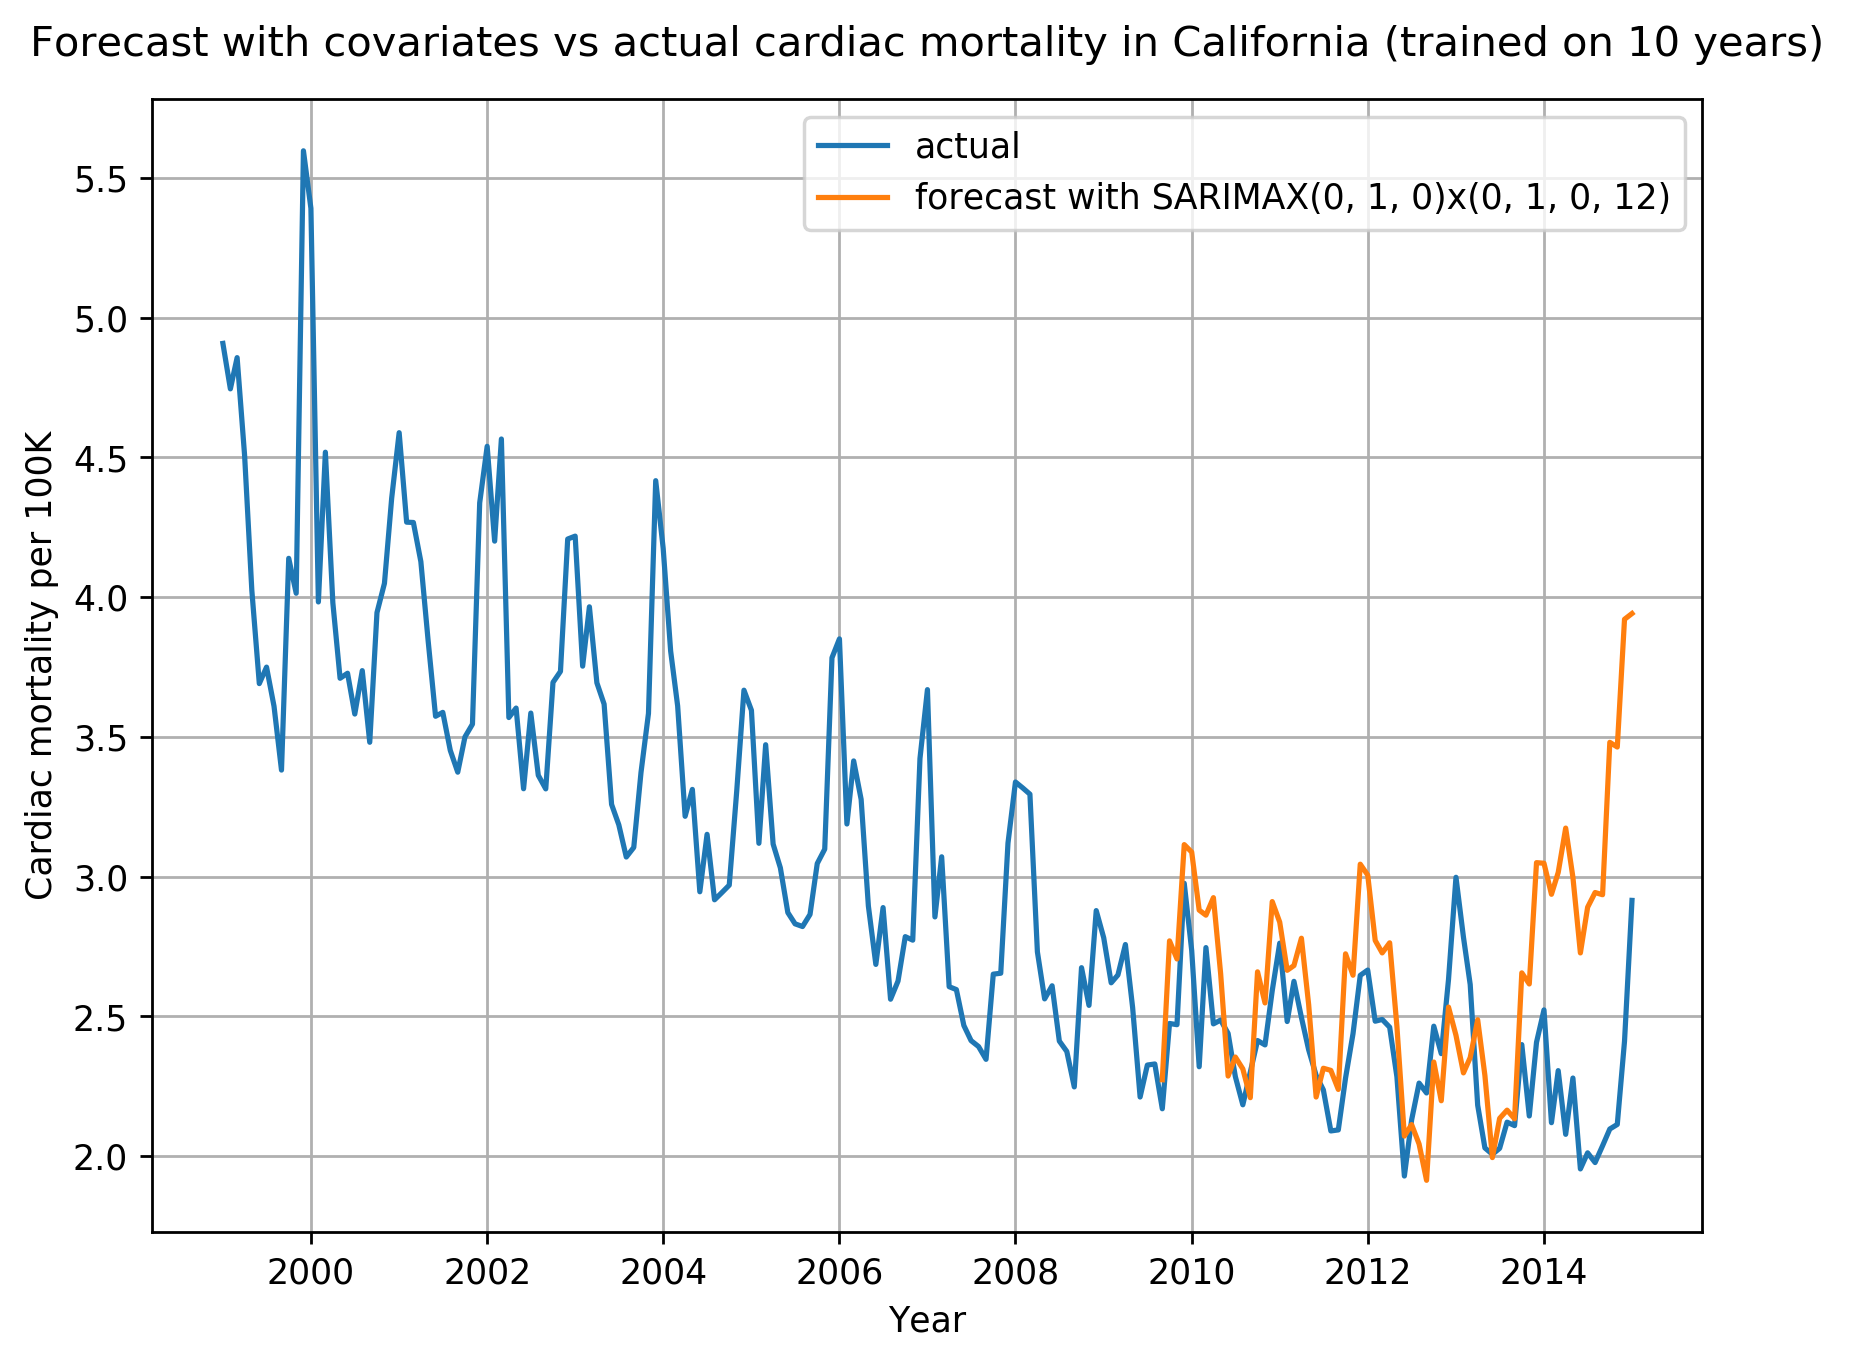

In [15]:
california_forecast = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[best_by_mse[0]], state_df.mortality_per_100k, train_fraction=0.66, exog_var=state_df.drop(columns=['mortality_per_100k']))

plt.plot(state_df.mortality_per_100k, label="actual")
plt.plot(california_forecast, label=f"forecast with SARIMAX{list_of_SARIMA_dicts[best_by_mse[0]]['order']}x{list_of_SARIMA_dicts[best_by_mse[0]]['seasonal']}")

plt.title("Forecast with covariates vs actual cardiac mortality in California (trained on 10 years)", y = 1.02)

plt.xlabel("Year")
plt.ylabel("Cardiac mortality per 100K")

plt.grid()
plt.legend()

#plt.savefig("../figures_2/california_forecast_ARIMAX_10y_with_cov.png")

plt.show()

## Feature importance by shuffling variables

Now, let's try shuffling each of the covariates and seeing which one decreases the test MSE the most. This will potentially give us some sense of which covariate is actually contributing the most to the model? It might also be interesting to see how the prediction changes if we change different covariates to different values.

In [19]:
def scramble_column(col, df):
    temp_df = df.copy()
    scramble_col = list(temp_df[col].sample(len(temp_df[col])))
    # we have to cast this as a list; sampling does scramble the records, but they retain their index, and so
    # when you set col equal to scamble col, it matches the values by index. Making it a list removes the index.
    temp_df[col] = scramble_col
    return temp_df

In [16]:
y = state_df.mortality_per_100k
X = state_df.drop(columns=['mortality_per_100k'])

In [21]:
# Without scrambling columns:
y_pred = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[best_by_mse[0]], y, train_fraction=0.66, exog_var=X)
y_test = y[y_pred.index]
    
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

0.5138725094944188


In [19]:
X.obesity_prevalence.head()

1999-01-01    0.415000
1999-02-01    0.413083
1999-03-01    0.411167
1999-04-01    0.409250
1999-05-01    0.407333
Name: obesity_prevalence, dtype: float64

In [20]:
z = scramble_column('obesity_prevalence', X)

In [21]:
z.obesity_prevalence.head()

1999-01-01    0.493250
1999-02-01    0.474250
1999-03-01    0.483583
1999-04-01    0.472500
1999-05-01    0.465333
Name: obesity_prevalence, dtype: float64

In [182]:
# Now, we iterate through each column and scramble them, and run the model and forecast.
scramble_var_rmse_dict = {}

for col in X.columns:
    print(f"Scrambling {col}.")
    scramble_df = scramble_column(col, X)
    
    y_pred = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[best_by_mse[0]], y, train_fraction=0.66, exog_var=scramble_df)
    y_test = y[y_pred.index]
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE is: {rmse}")
    scramble_var_rmse_dict[col] = rmse

Scrambling obesity_prevalence.
RMSE is: 2.291641329804946
Scrambling diabetes_prevalence.
RMSE is: 0.7870004689387
Scrambling high_cholesterol.
RMSE is: 3.0893296471264495
Scrambling hypertension.
RMSE is: 1.8778518995545088
Scrambling exercise.
RMSE is: 1.793462113114531
Scrambling general_health.
RMSE is: 0.309123147876394
Scrambling mental_health.
RMSE is: 2.7835044759715184
Scrambling coverage.
RMSE is: 4.786331337283763
Scrambling income.
RMSE is: 1.5330049534538632
Scrambling smoker.
RMSE is: 1.9006792970356958
Scrambling med_cost.
RMSE is: 2.988309519484528
Scrambling gender.
RMSE is: 0.558752811383807


But the increase in RMSE depends on how each feature was scrambled, and actually we can see that scrambling general_health actually gave us a *lower* RMSE than the original data set! Therefore, what we should do to get a more realistic value is to scramble each column many times (e.g. 100 times), then take the average RMSE for that variable getting scrambled.

In [189]:
# Now, we iterate through each column and scramble them, and run the model and forecast.
scramble_var_rmse_dict = {}

for i in log_progress(range(100)):
    for col in X.columns:
        scramble_df = scramble_column(col, X)

        y_pred = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[best_by_mse[0]], y, train_fraction=0.66, exog_var=scramble_df)
        y_test = y[y_pred.index]

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        if col in scramble_var_rmse_dict:
            scramble_var_rmse_dict[col].append(rmse)
        else:
            scramble_var_rmse_dict[col] = [rmse]

In [195]:
mean_scramble_var_rmse = {}

for var, rmse_list in scramble_var_rmse_dict.items():
    mean_scramble_var_rmse[var] = np.mean(rmse_list)

In [197]:
mean_scramble_var_rmse_df = pd.DataFrame({"var_name": list(mean_scramble_var_rmse.keys()), "increase_in_RMSE": list(mean_scramble_var_rmse.values())})

In [198]:
print(mean_scramble_var_rmse_df.sort_values(by='increase_in_RMSE', ascending=False).rename(columns={'var_name': 'Variable', 'increase_in_RMSE': 'Increase in RMSE'}))

               Variable  Increase in RMSE
7              coverage          4.208718
6         mental_health          3.144527
9                smoker          3.032097
2      high_cholesterol          2.909966
10             med_cost          2.627536
0    obesity_prevalence          1.871008
3          hypertension          1.782874
4              exercise          1.771485
8                income          1.484605
5        general_health          0.936332
11               gender          0.641092
1   diabetes_prevalence          0.628851


So we can see that for California, scrambling the variables for coverage, mental health, and smoker caused the largest increase in RMSE. All of those variables are trending the right way were we would, in fact, expect deaths due to heart attack to go down, although other variables are trending in a 'worse direction'. E.g., if we do a sanity check and look at the 'high cholesterol' variable, we see that its prevalence is trending up. That means that the model is learning that higher levels of cholesterol are associated with lower rates of heart disease.

In [108]:
plt.rcParams['figure.figsize'] = [8.0, 4.0]
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 250

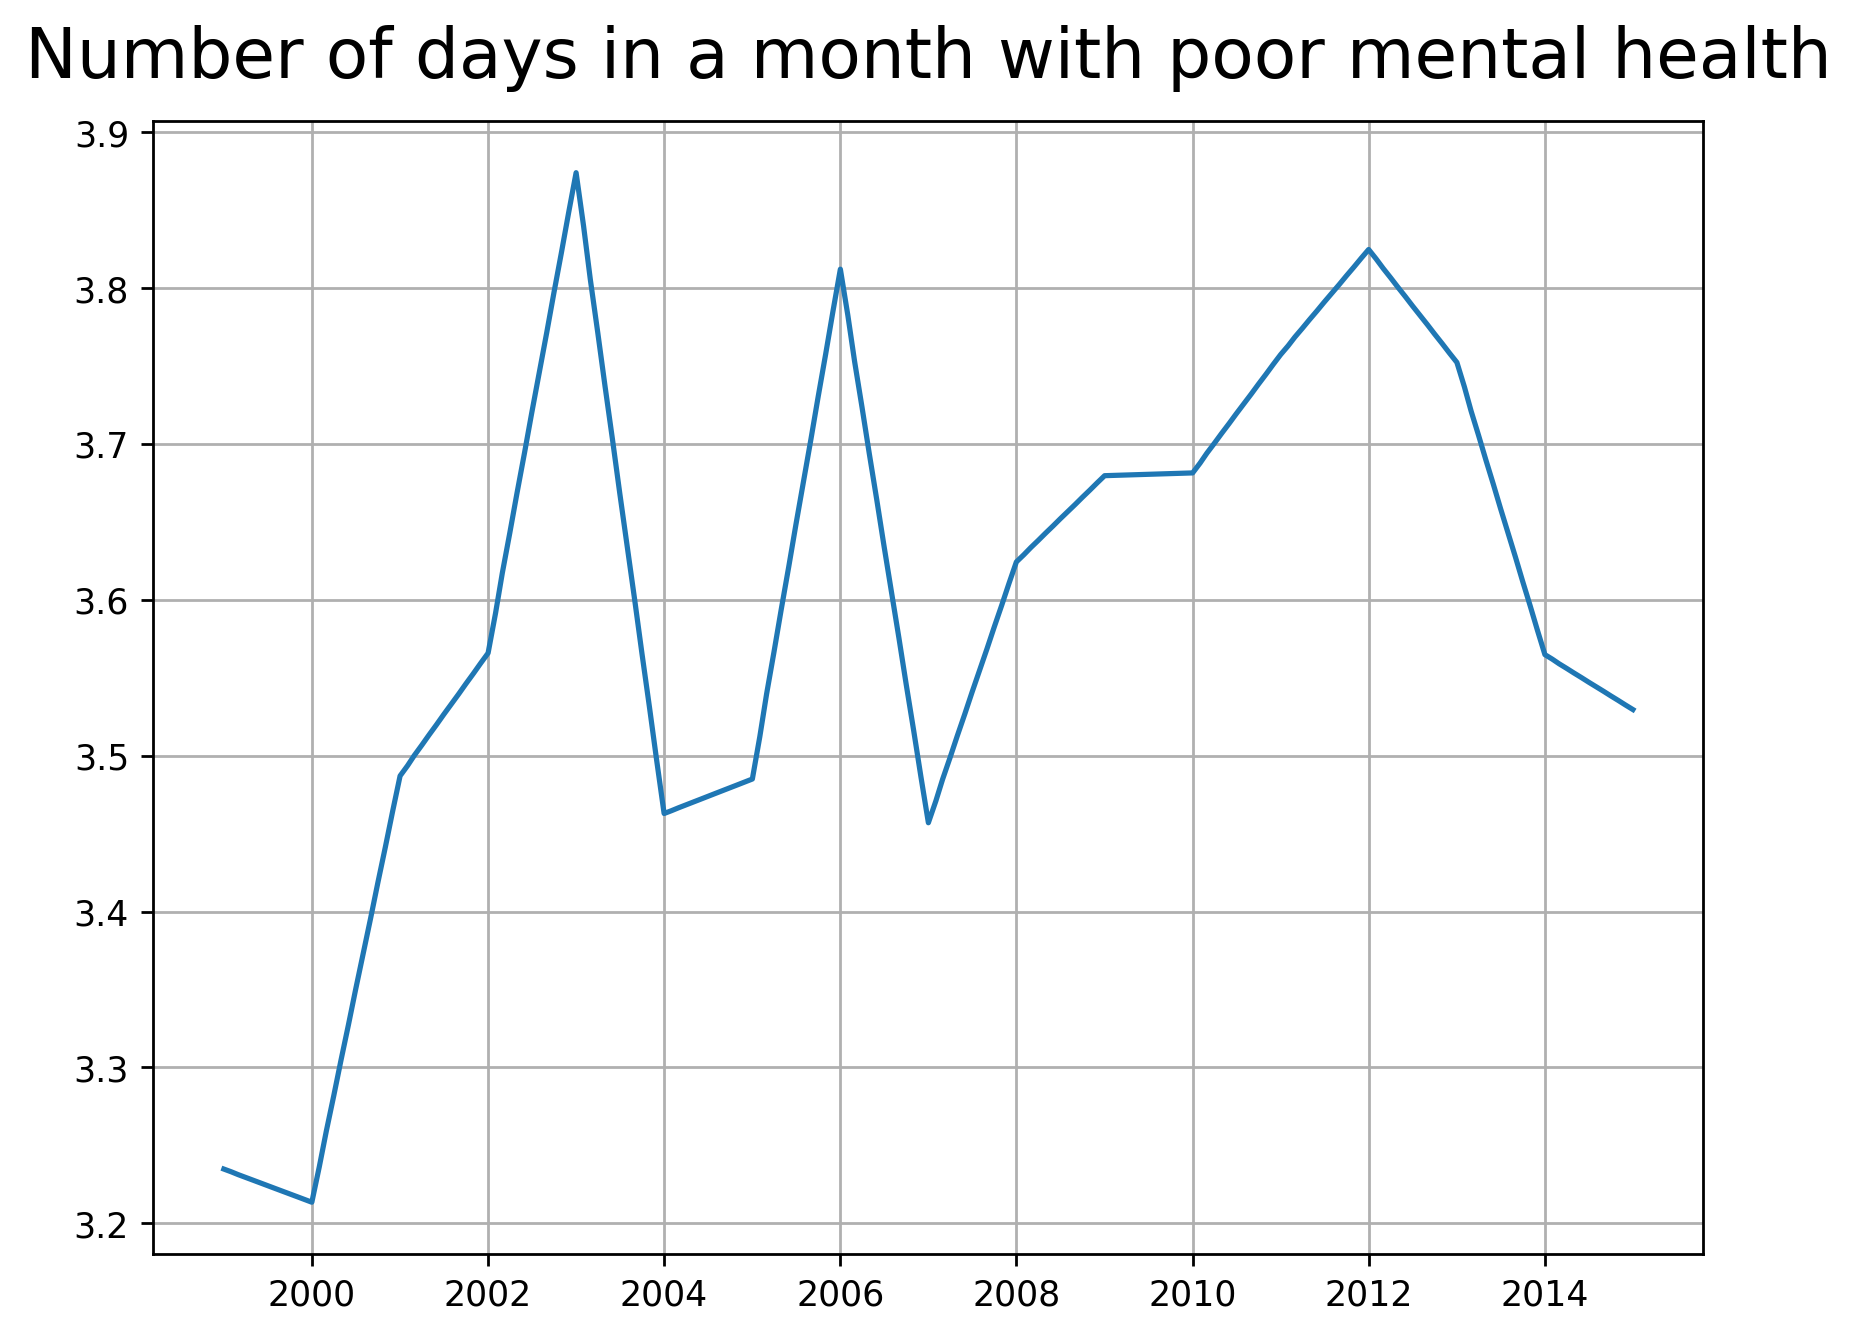

In [201]:
plt.plot(state_df.mental_health, label='California')
# plt.xlabel('Year')
plt.ylabel('')

plt.title("Number of days in a month with poor mental health", y = 1.02, fontsize=20)
plt.grid()

# plt.savefig("../figures_2/california_coverage.png", transparent=True)

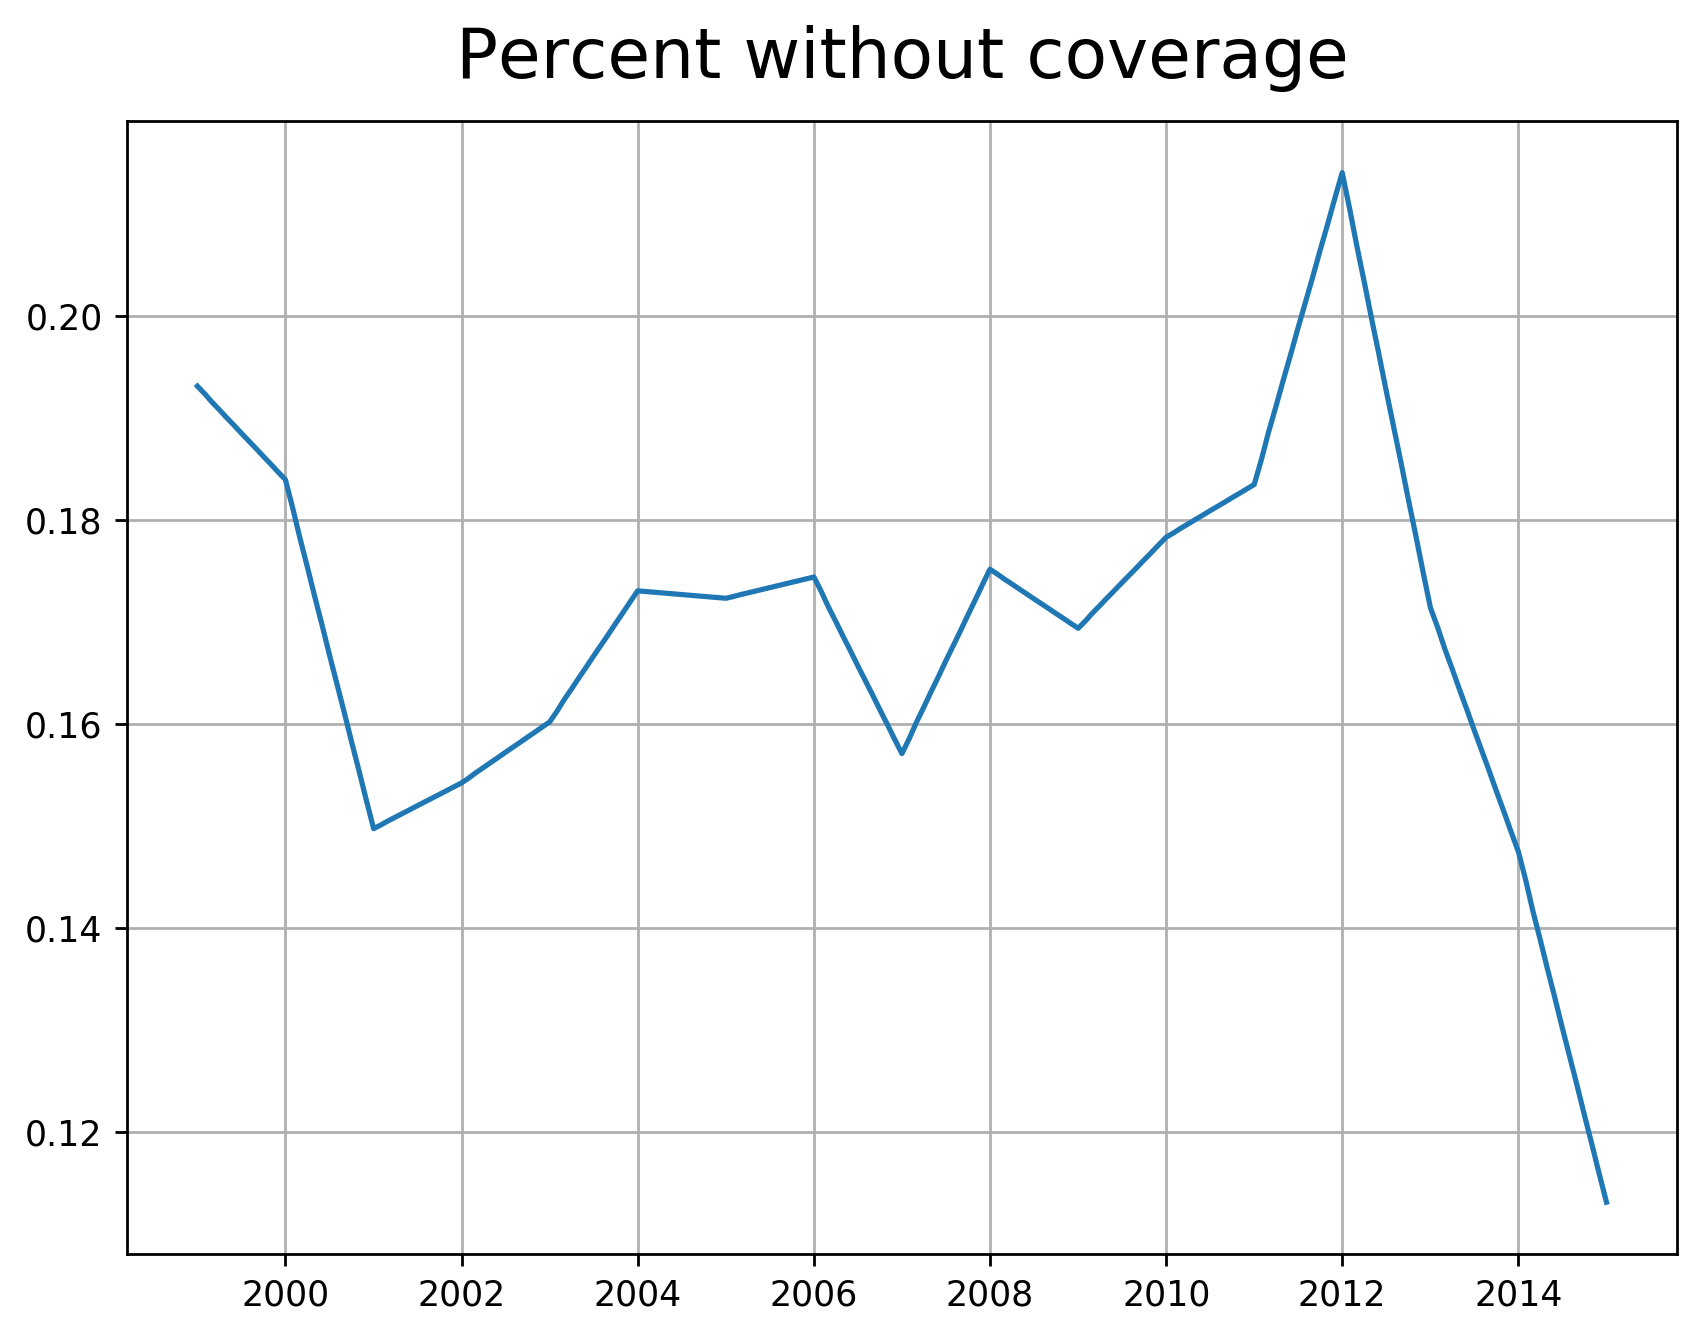

In [200]:
plt.plot(state_df.coverage, label='California')
# plt.xlabel('Year')
plt.ylabel('')

plt.title("Percent without coverage", y = 1.02, fontsize=20)
plt.grid()

# plt.savefig("../figures_2/california_coverage.png", transparent=True)

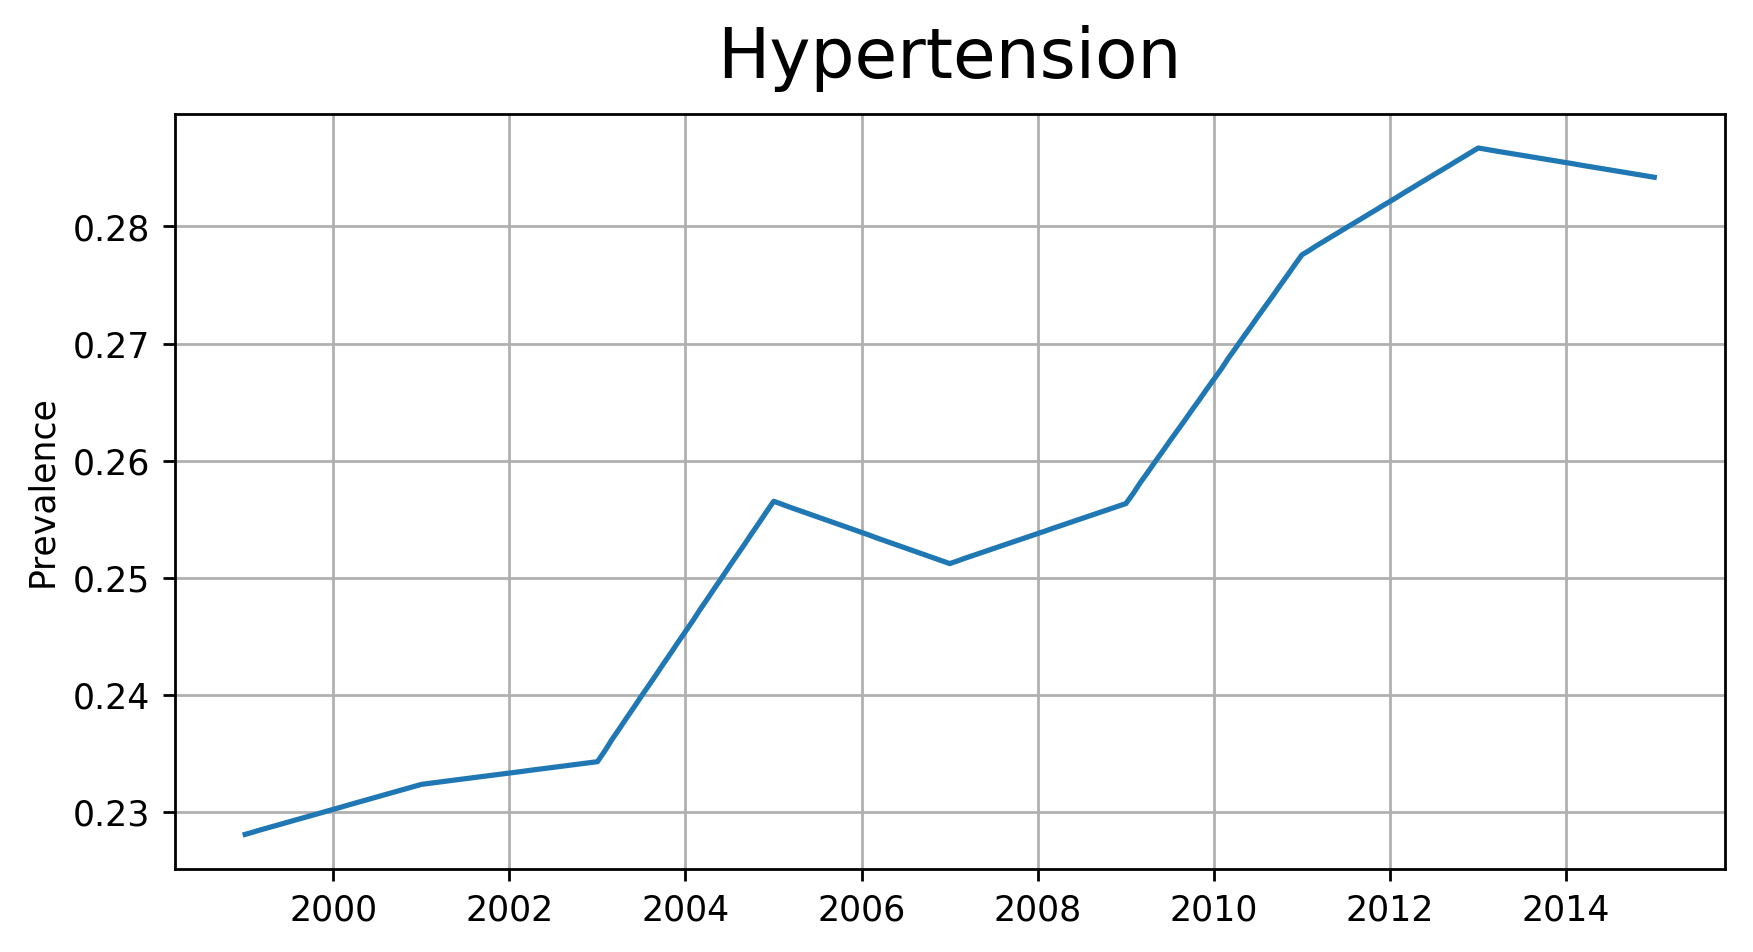

In [113]:
plt.plot(state_df.hypertension, label='California')
# plt.xlabel('Year')
plt.ylabel('Prevalence')

plt.title("Hypertension", y = 1.02, fontsize=20)
plt.grid()

plt.savefig("../figures_2/california_hypertension_prevalence.png", transparent=True)

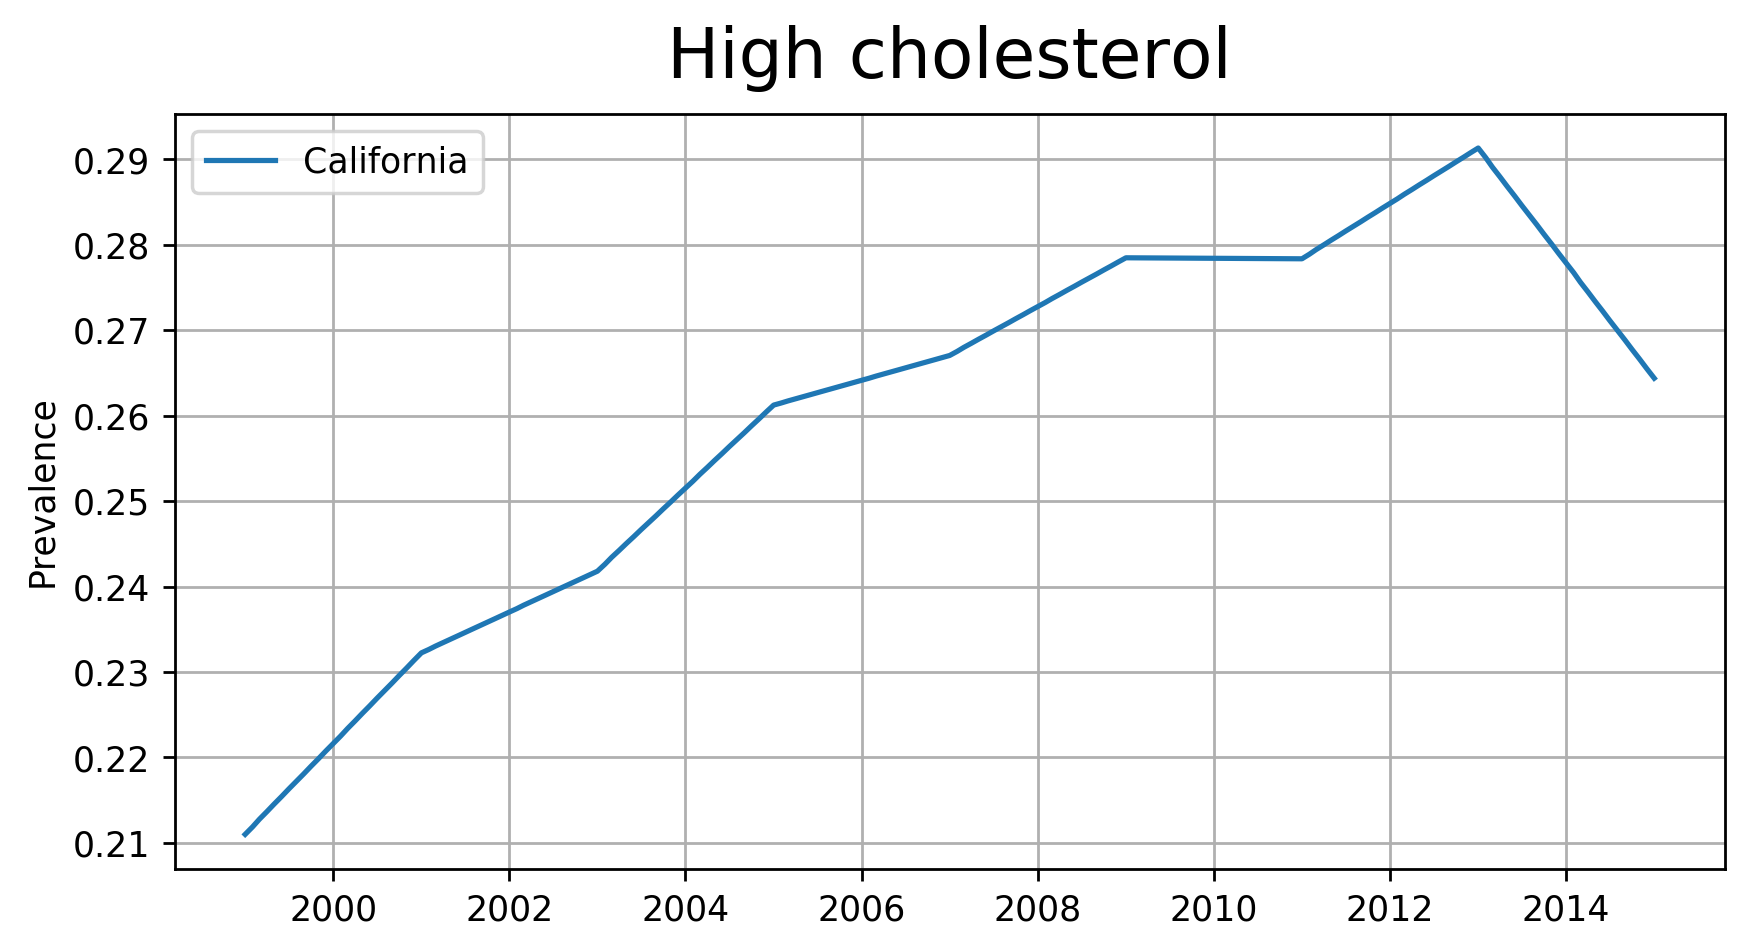

In [114]:
plt.plot(state_df.high_cholesterol, label='California')
plt.title("High cholesterol", y = 1.02, fontsize=20)
# plt.xlabel('Year')
plt.ylabel('Prevalence')
plt.grid()
plt.legend()

plt.savefig("../figures_2/california_hyperlipidemia_prevalence.png", transparent=True)

Well, we could see if we would be able to generalize this, but these models already fail the sanity check, so I don't think it's actually worth it to iterate through the rest of the states and to calculate the feature importance for each state-specific model. Instead, let's move on to seeing what the effect on the prediction is when you max out each feature (e.g. 1 or 100% for the prevalence questions, and 30 for mental health, etc.)

## Effect of saturating/maxing out each variable

Now, let's modify the exog predictors and saturate each variable in turn, and see what happens.

In [14]:
train_fraction = 0.66
y = state_df.mortality_per_100k
X = state_df.drop(columns=['mortality_per_100k'])

In [17]:
max_variable_in_exog_df('obesity_prevalence', X, train_fraction).tail()

/Users/joycelee/metis/projects/project_5/notebooks_2/sarimax_helper_functions.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exog_series_test[var] = max_value_for_var[var]


,obesity_prevalence,diabetes_prevalence,high_cholesterol,hypertension,exercise,general_health,mental_health,coverage,income,smoker,med_cost,gender
2014-09-01,1.0,0.09700,0.268877,0.284606,0.175801,0.180247,3.541403,0.124548,45.807518,0.108507,0.125652,0.492718
2014-10-01,1.0,0.09675,0.267754,0.284502,0.174303,0.180140,3.538465,0.121687,46.070386,0.107427,0.124592,0.492730
2014-11-01,1.0,0.09650,0.266632,0.284398,0.172804,0.180033,3.535527,0.118826,46.333254,0.106347,0.123531,0.492741
2014-12-01,1.0,0.09625,0.265509,0.284294,0.171306,0.179926,3.532590,0.115966,46.596122,0.105267,0.122470,0.492752
2015-01-01,1.0,0.09600,0.264386,0.284190,0.169808,0.179819,3.529652,0.113105,46.858991,0.104187,0.121410,0.492763


Maxing out obesity_prevalence in the test fraction:


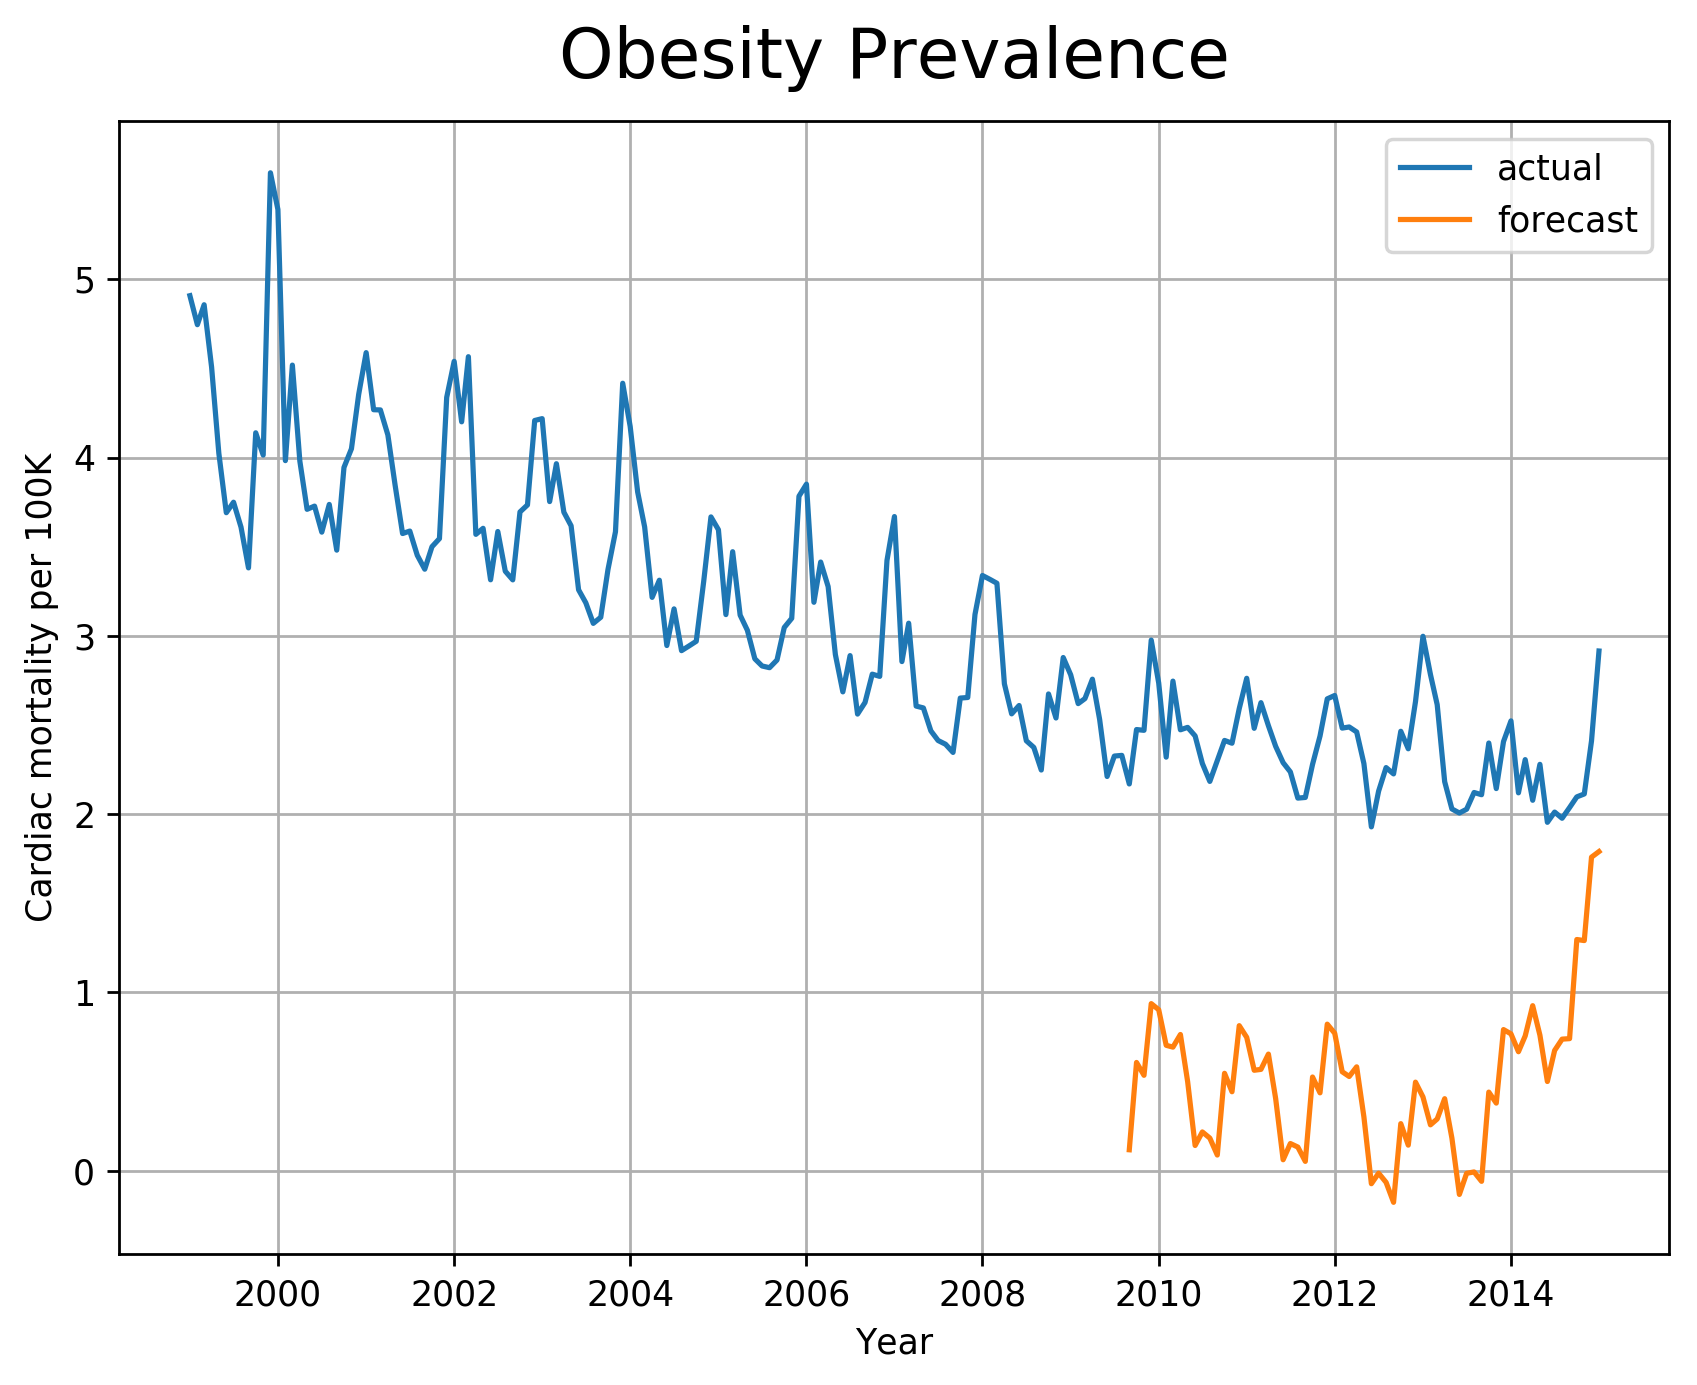

Maxing out diabetes_prevalence in the test fraction:


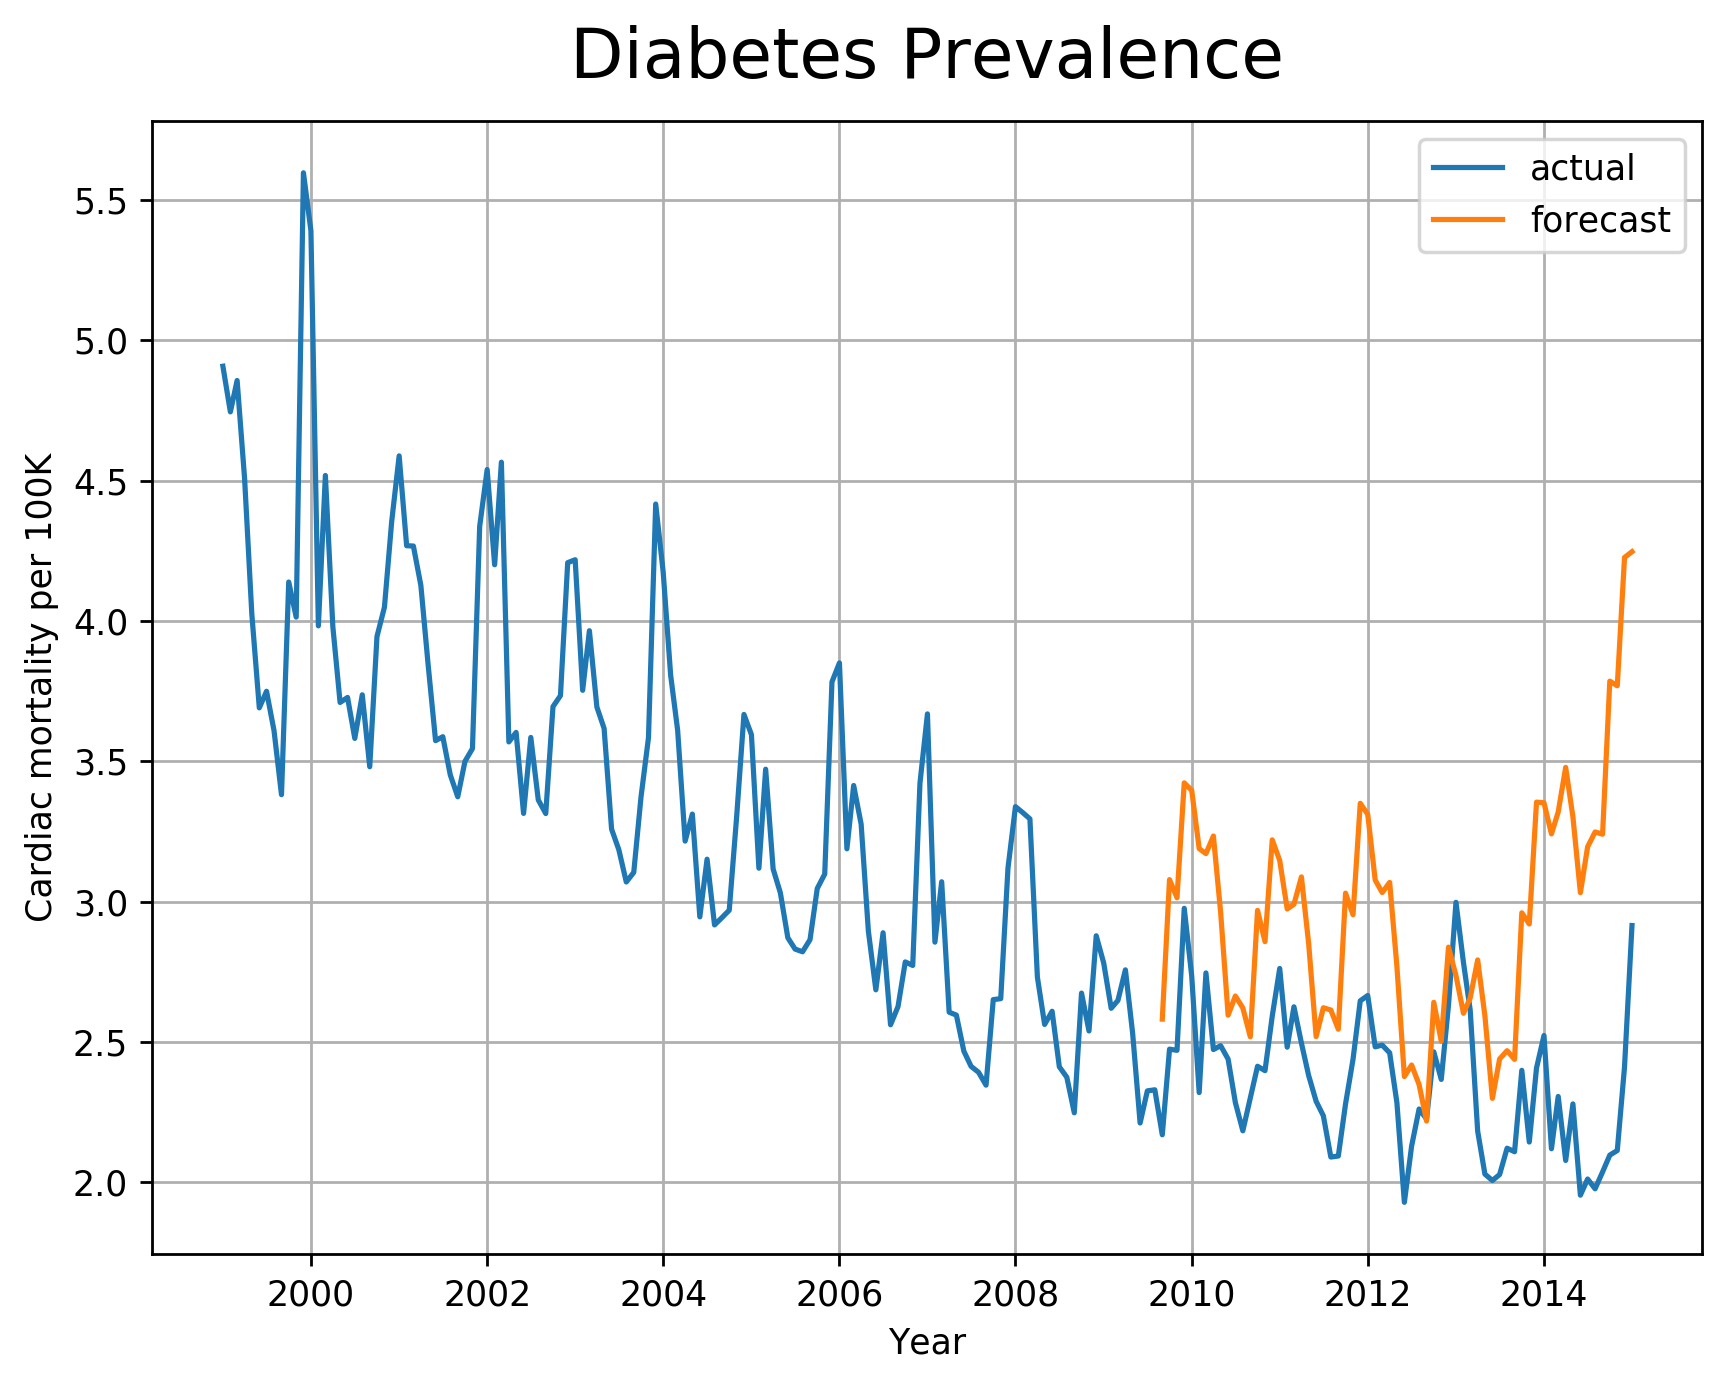

Maxing out high_cholesterol in the test fraction:


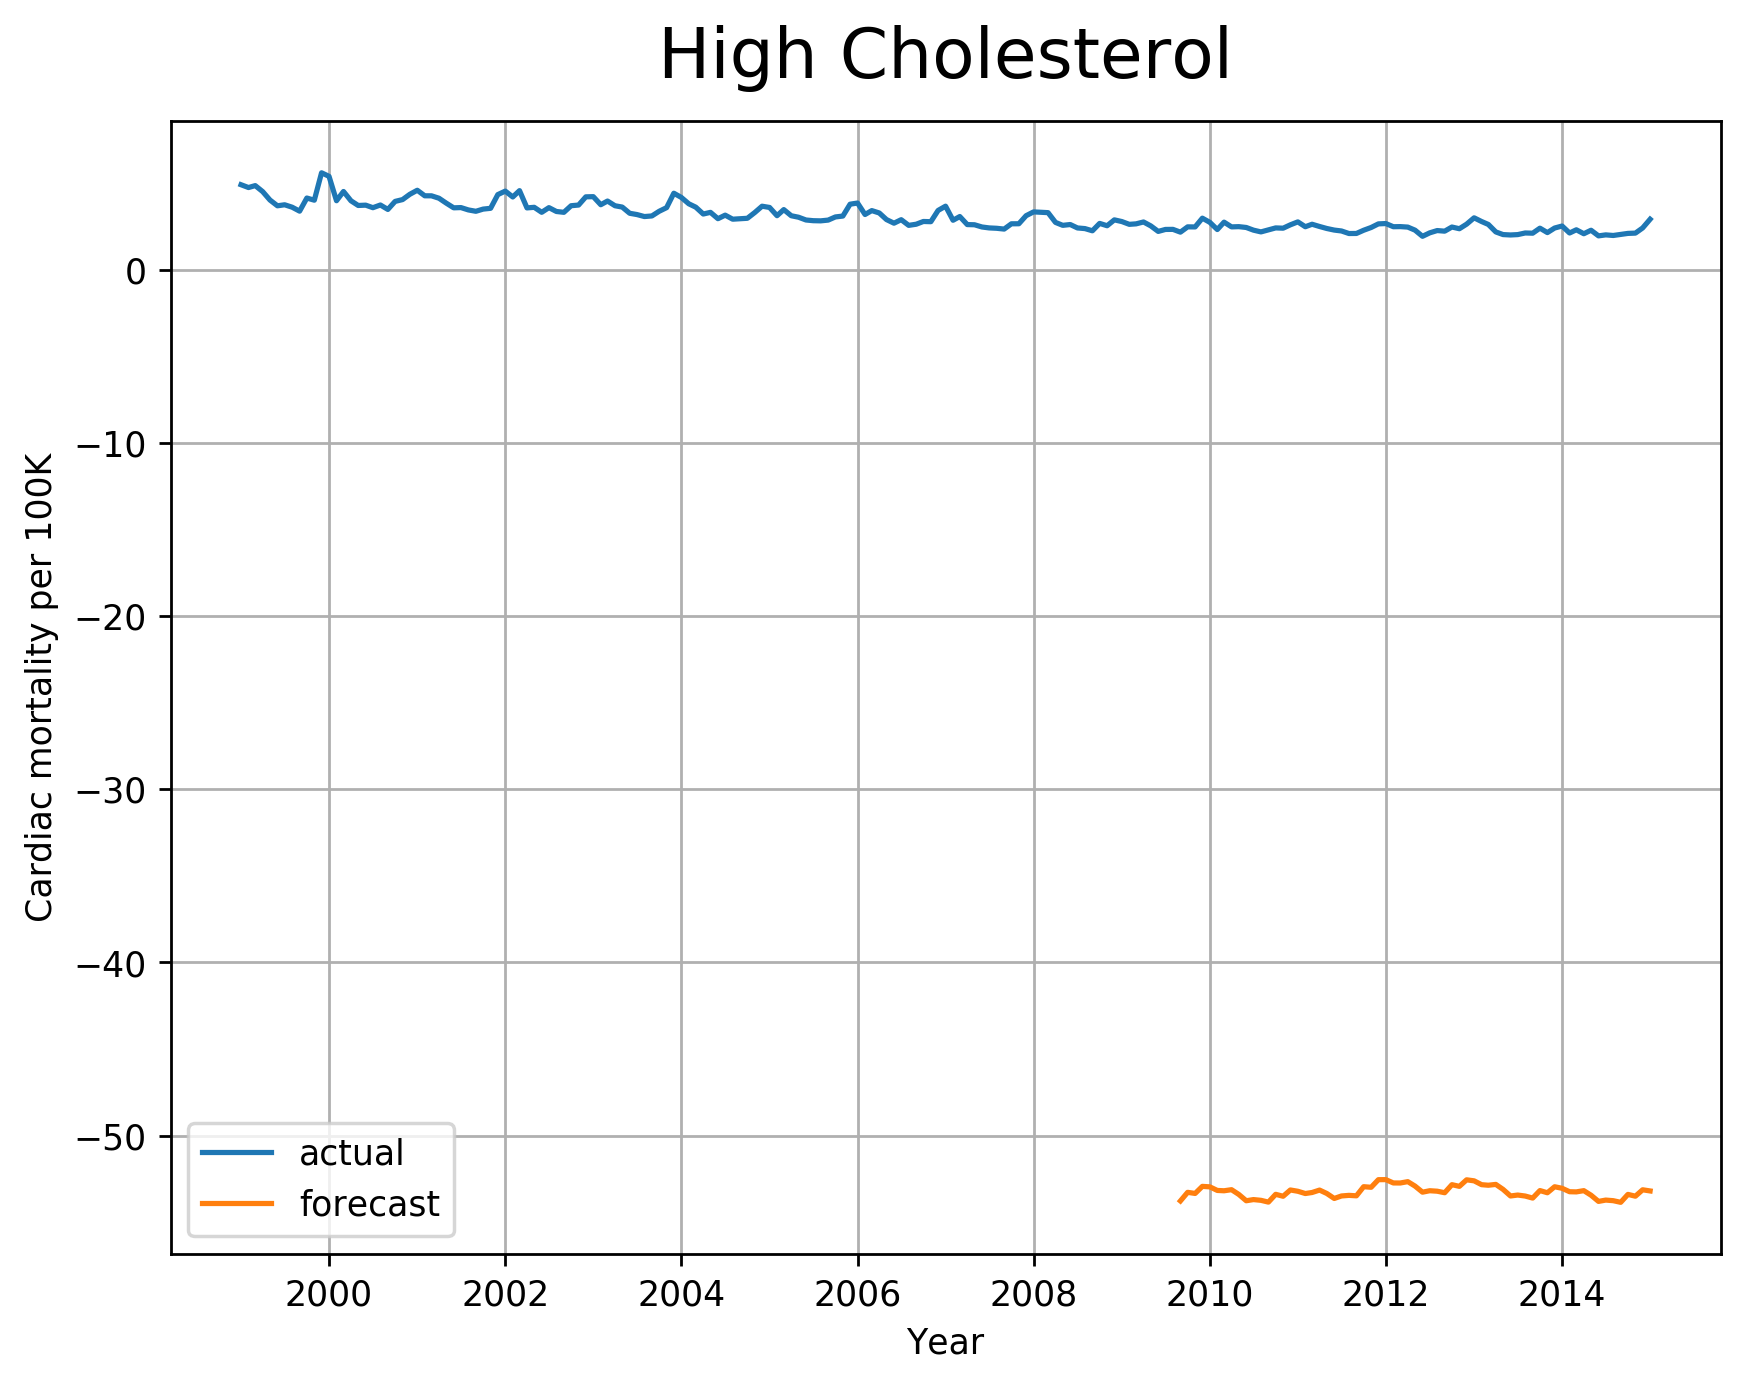

Maxing out hypertension in the test fraction:


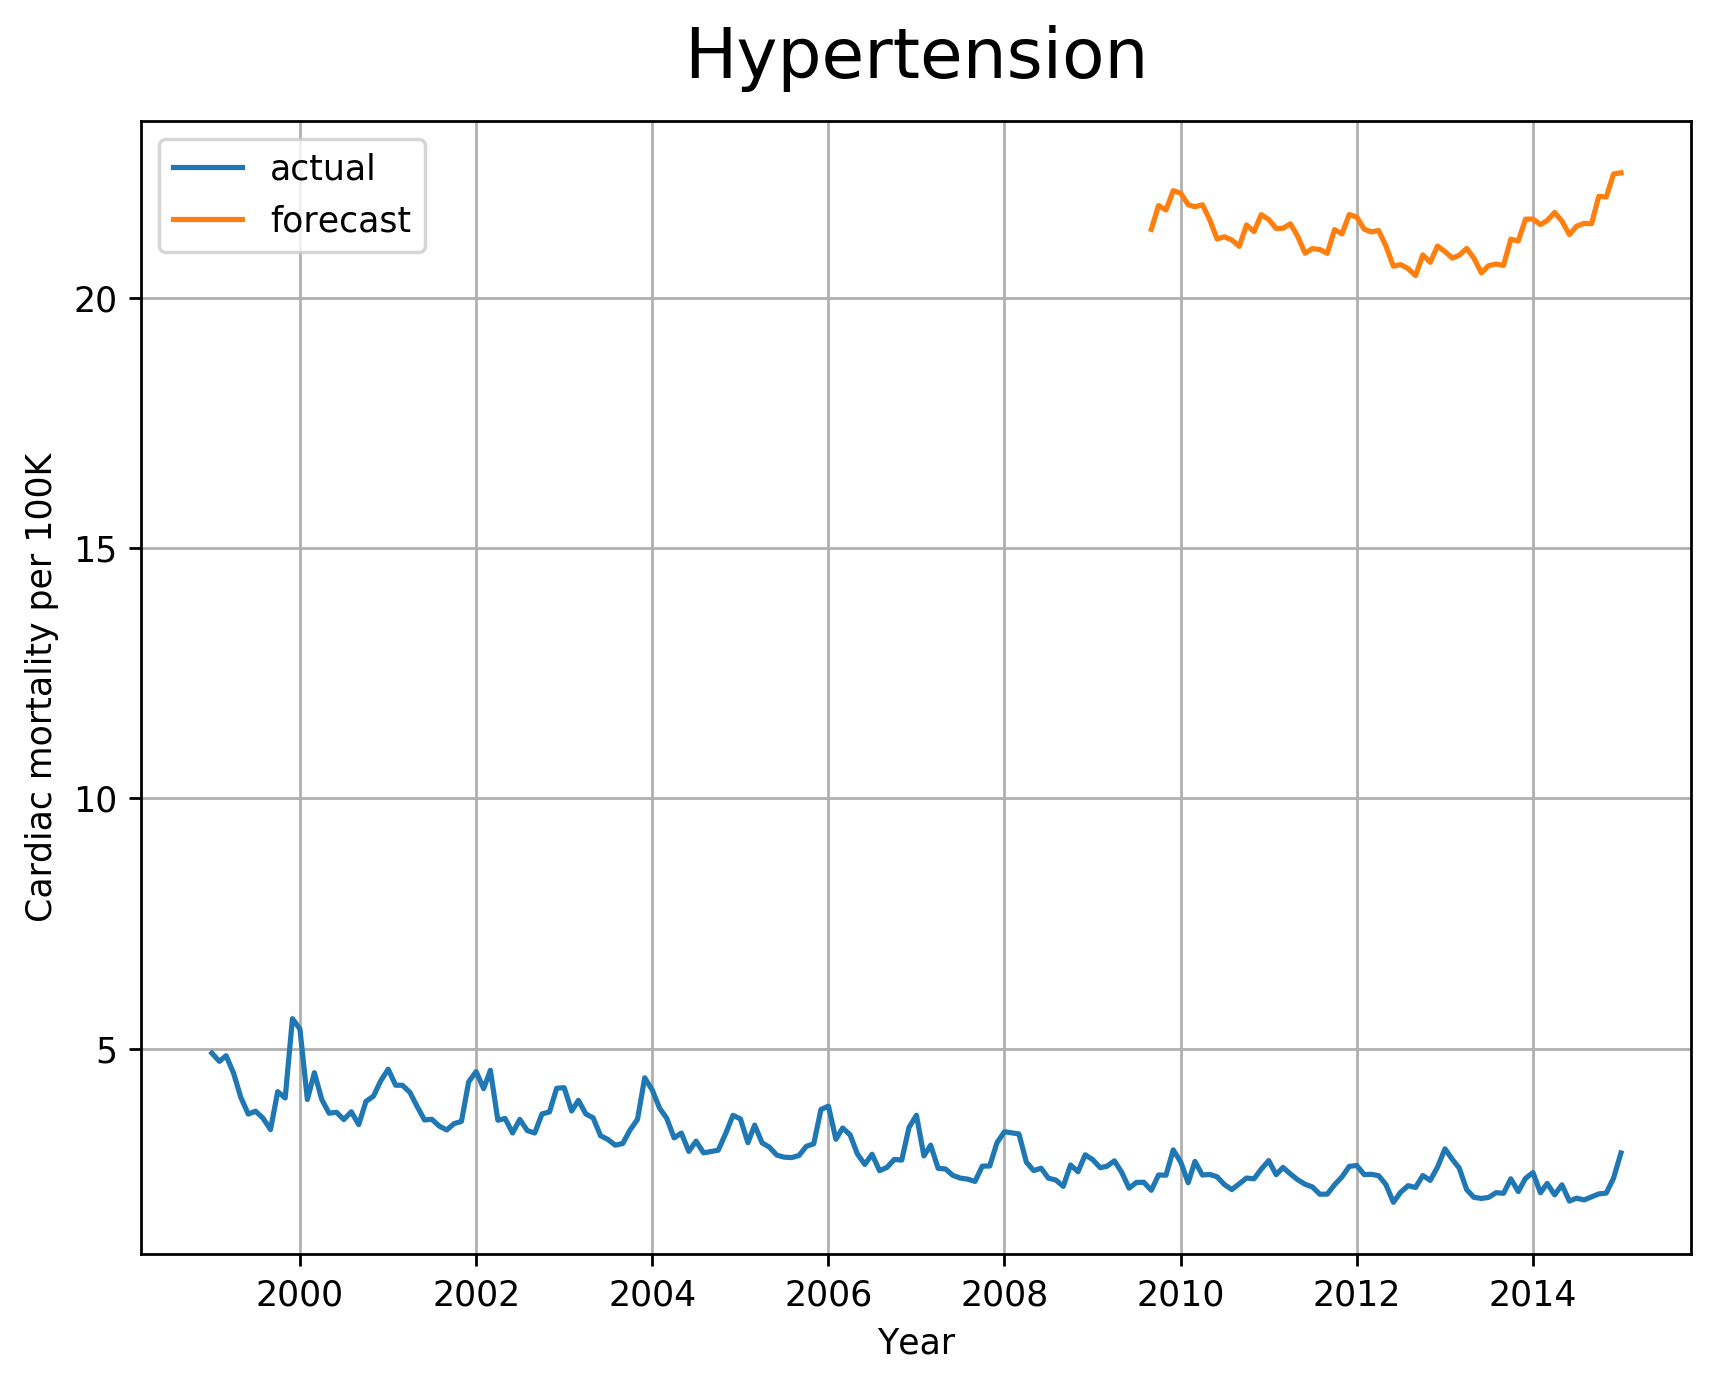

Maxing out exercise in the test fraction:


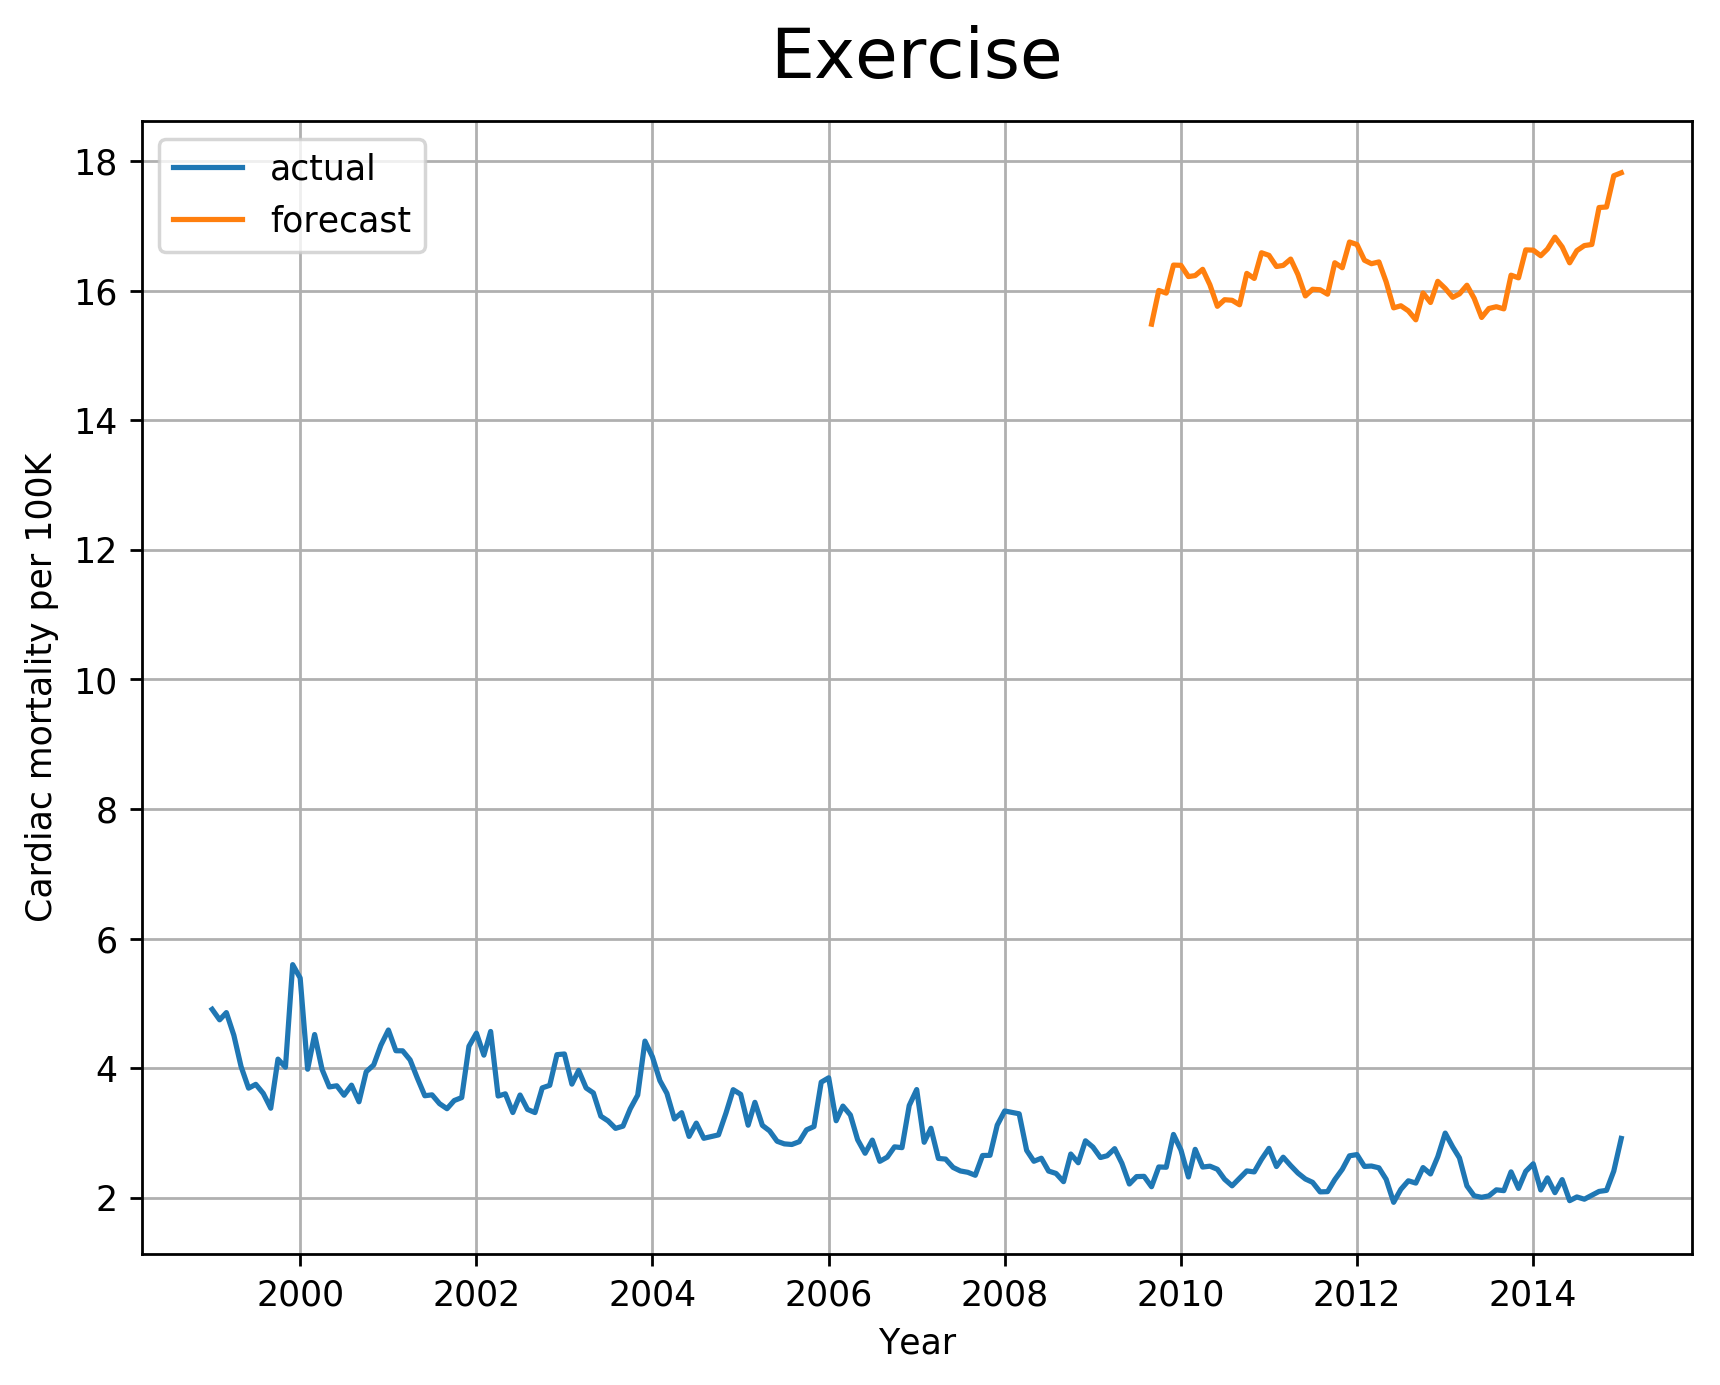

Maxing out general_health in the test fraction:


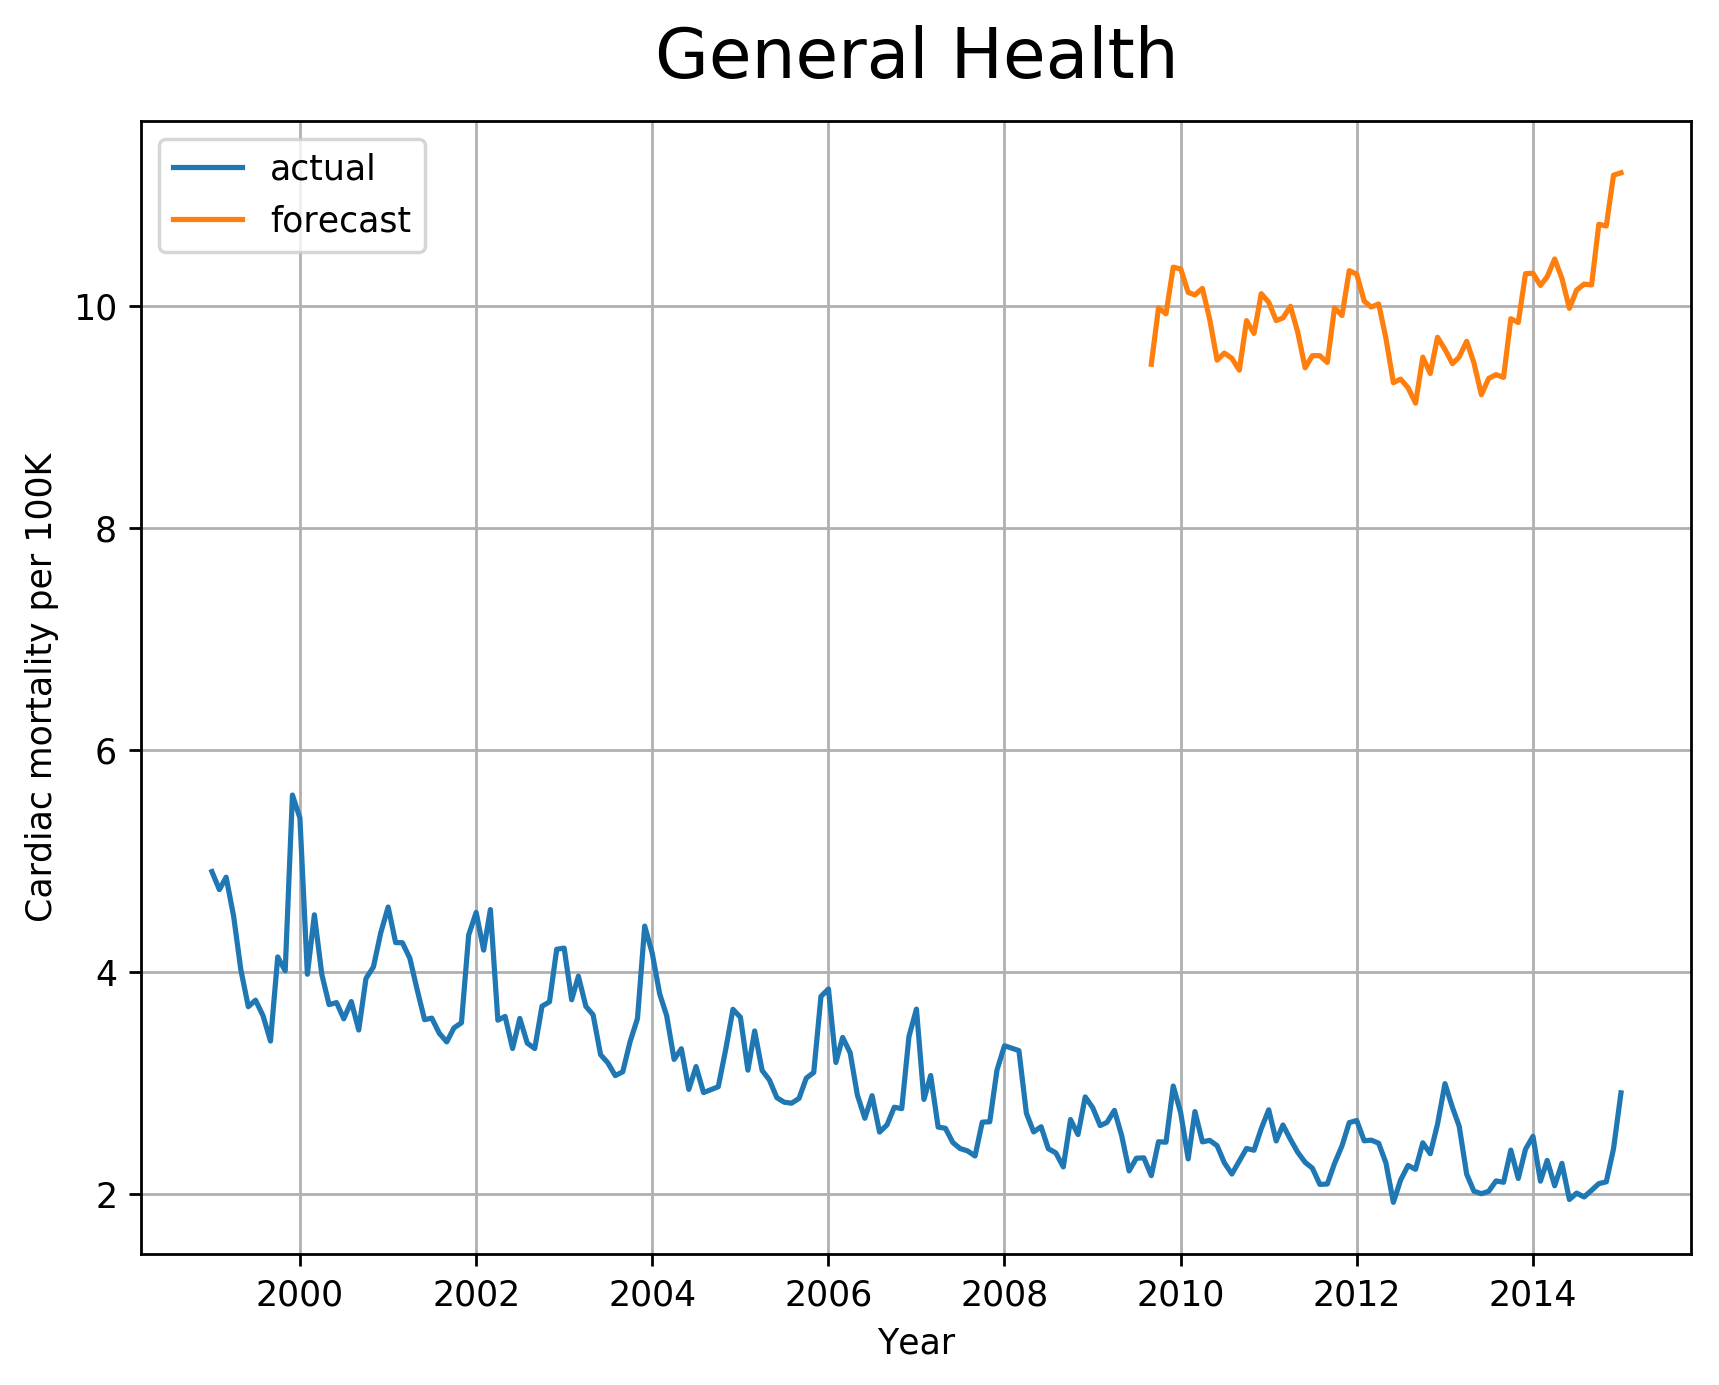

Maxing out mental_health in the test fraction:


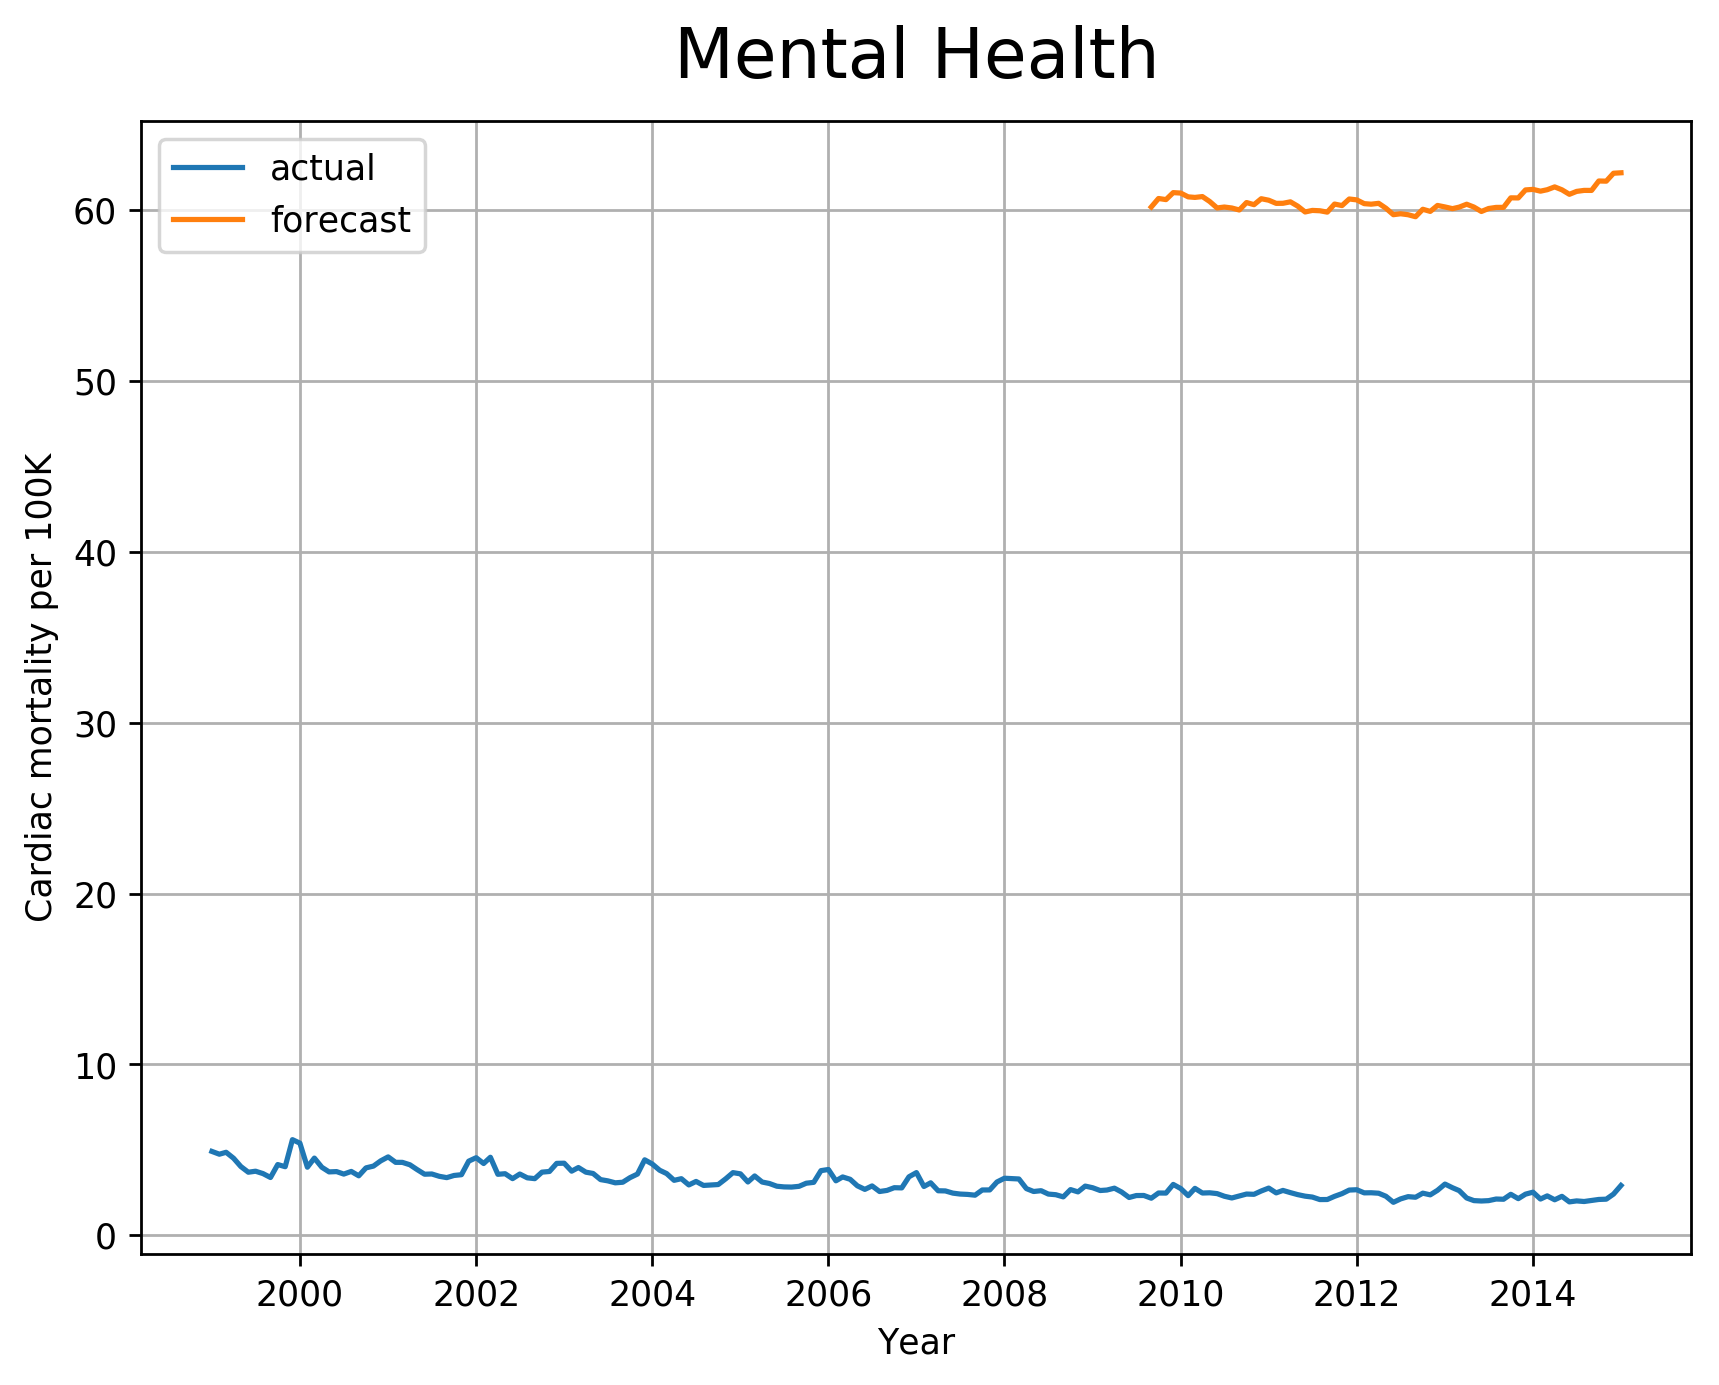

Maxing out coverage in the test fraction:


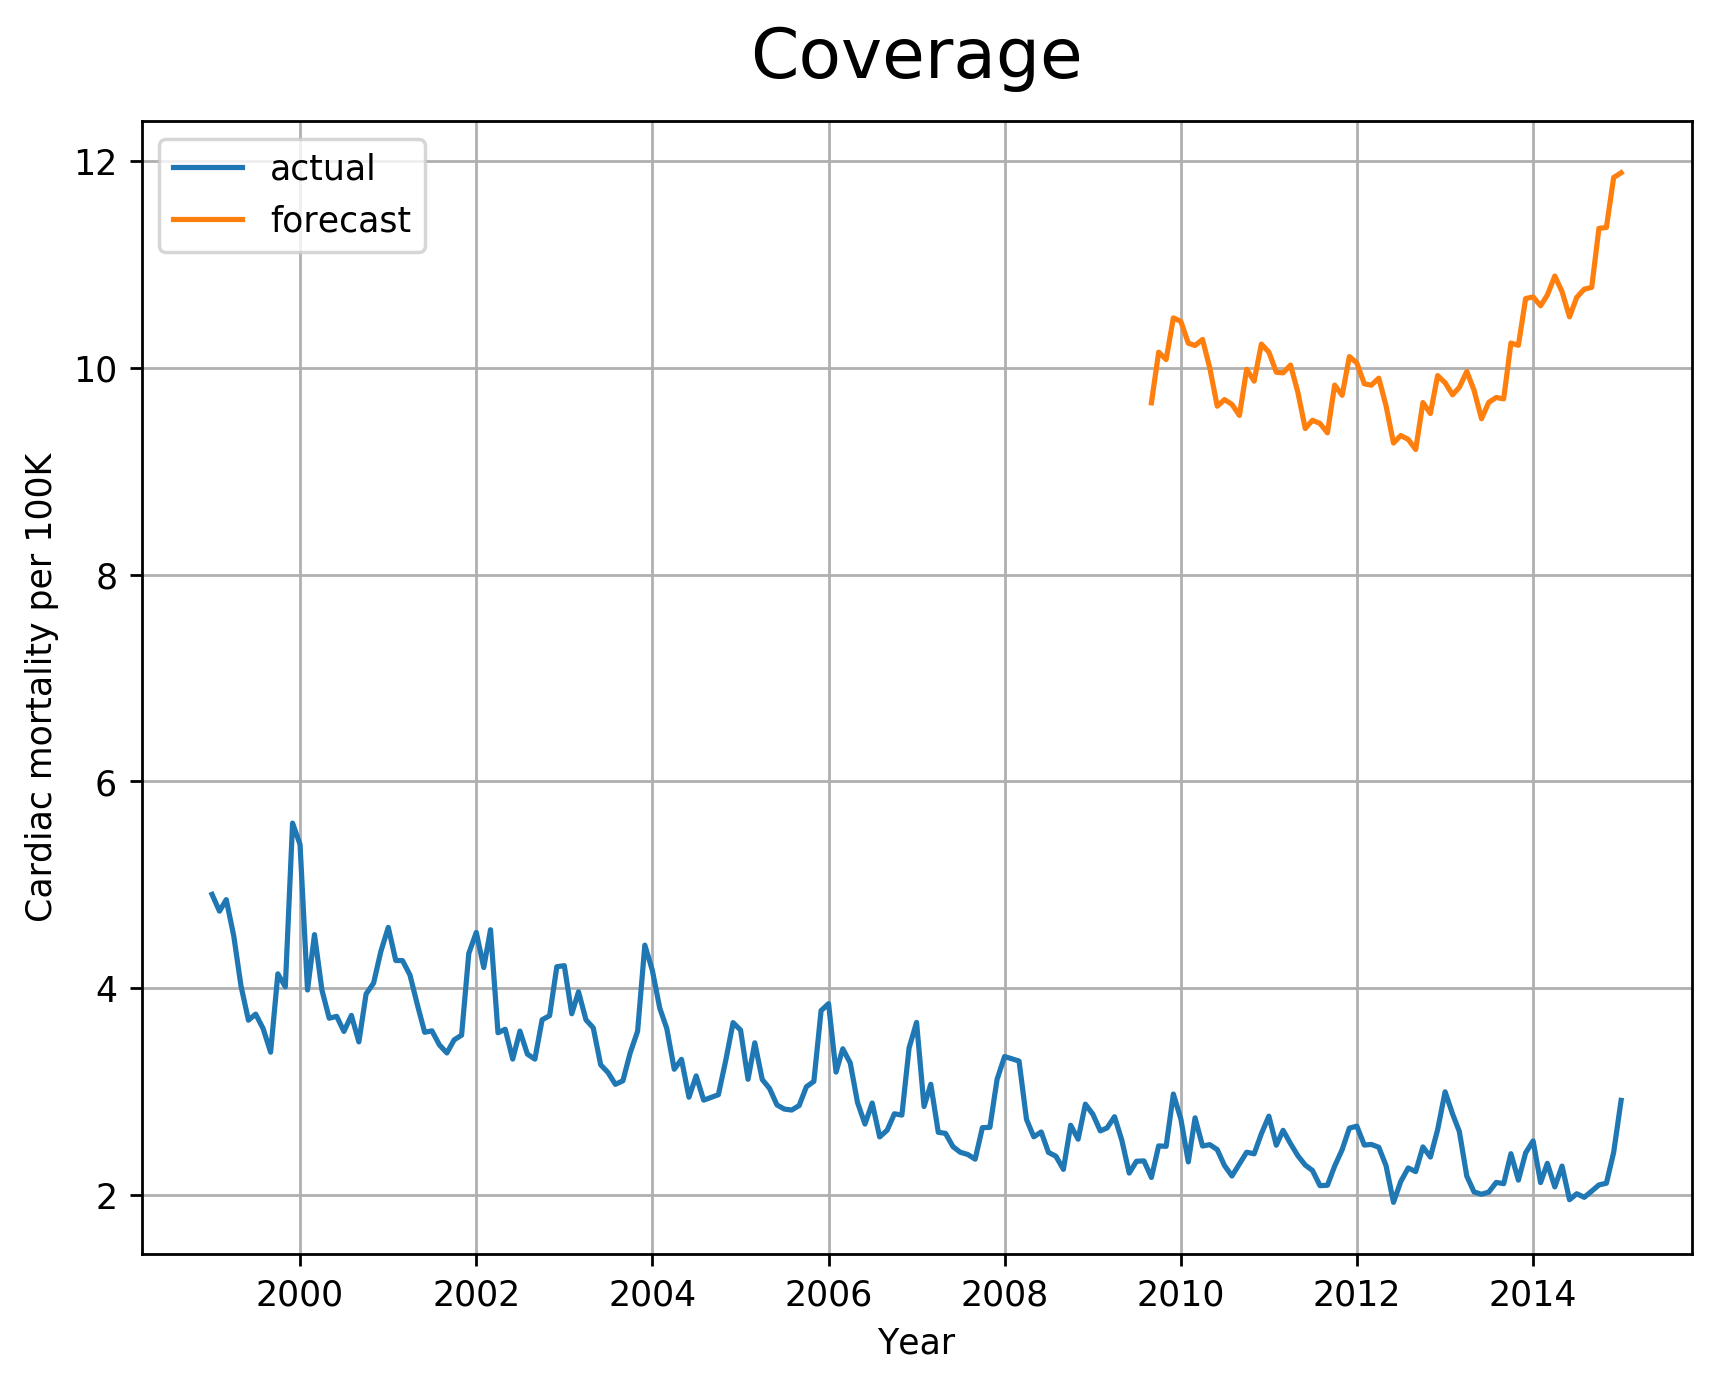

Maxing out income in the test fraction:


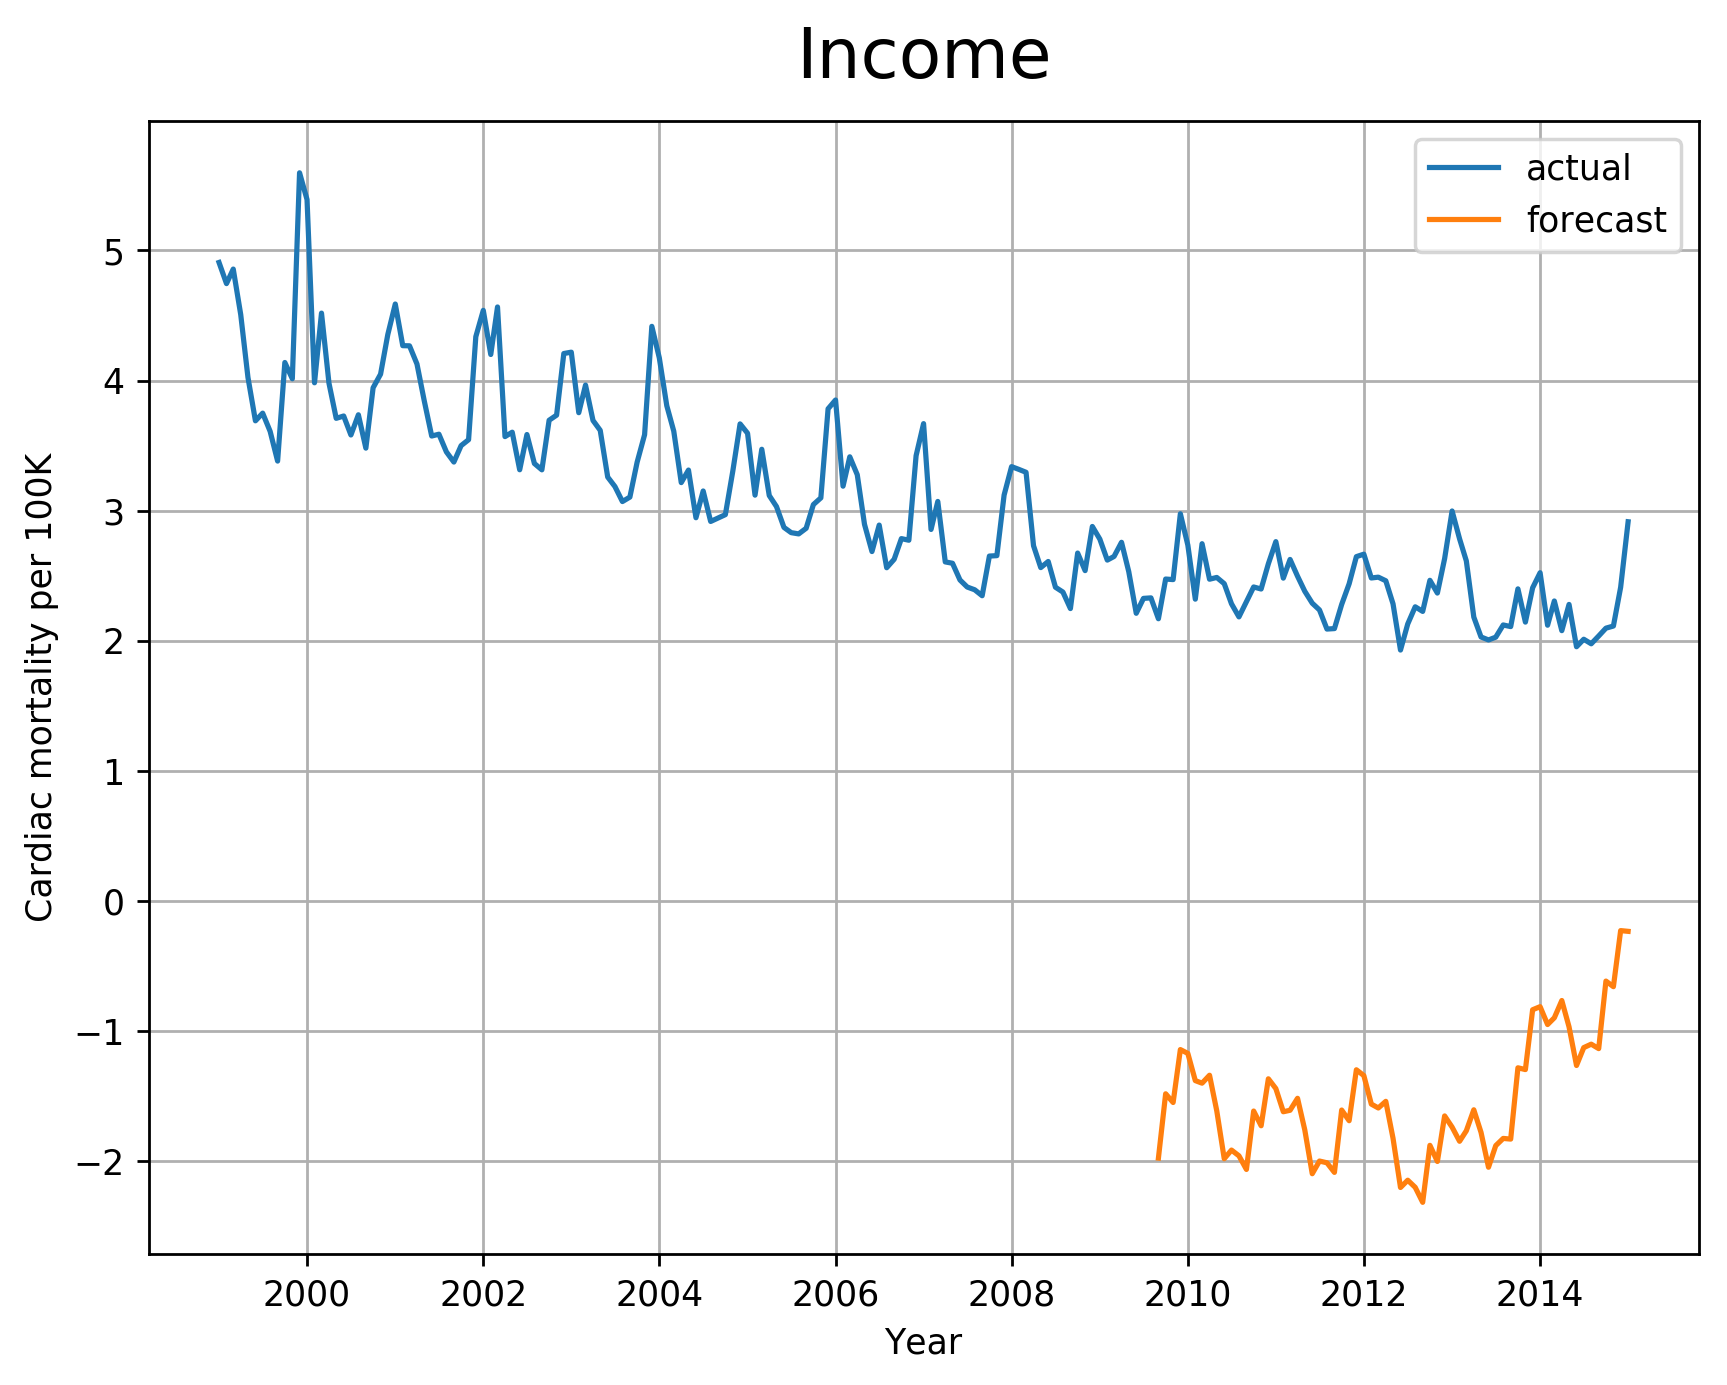

Maxing out smoker in the test fraction:


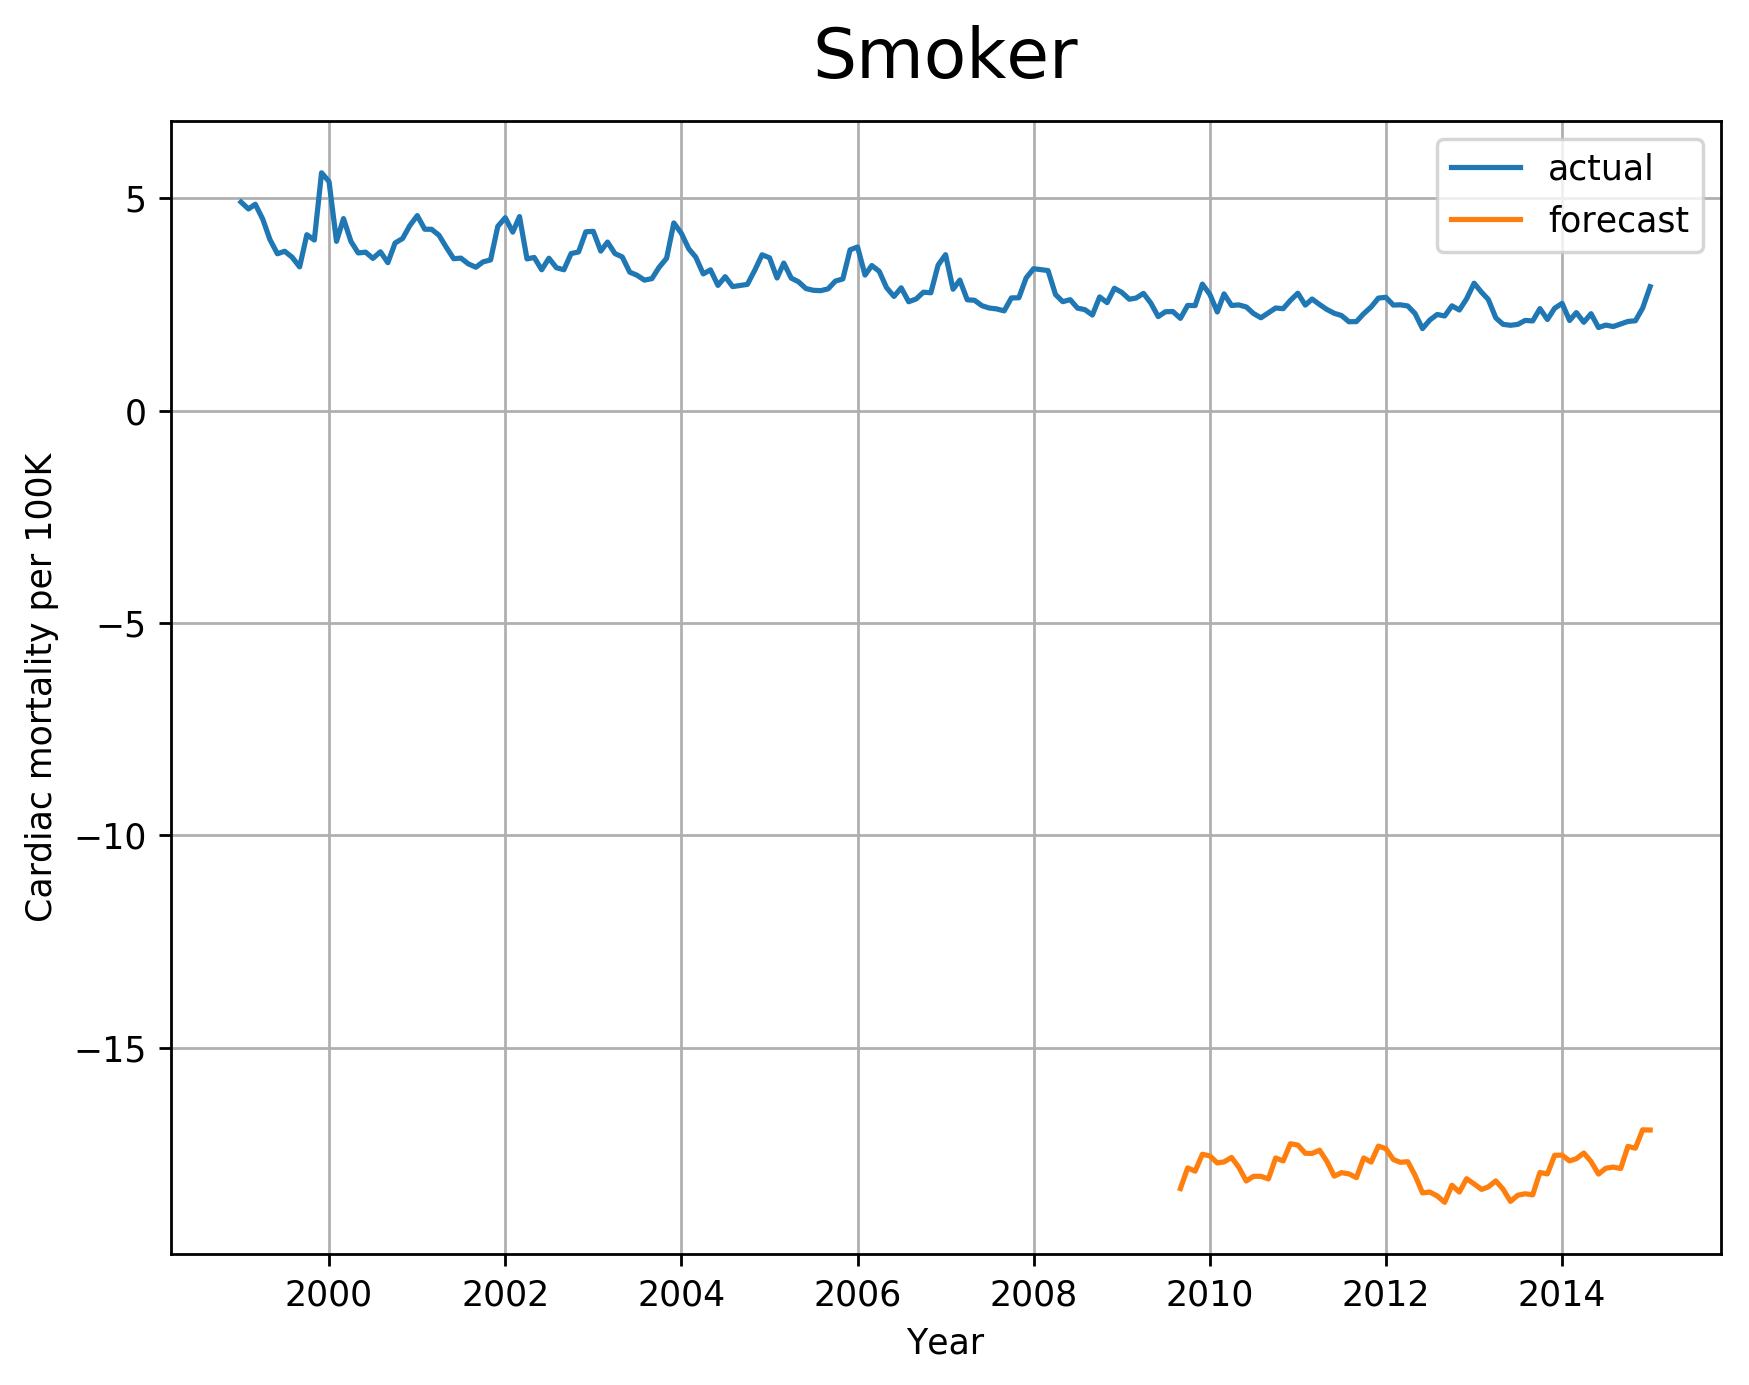

Maxing out med_cost in the test fraction:


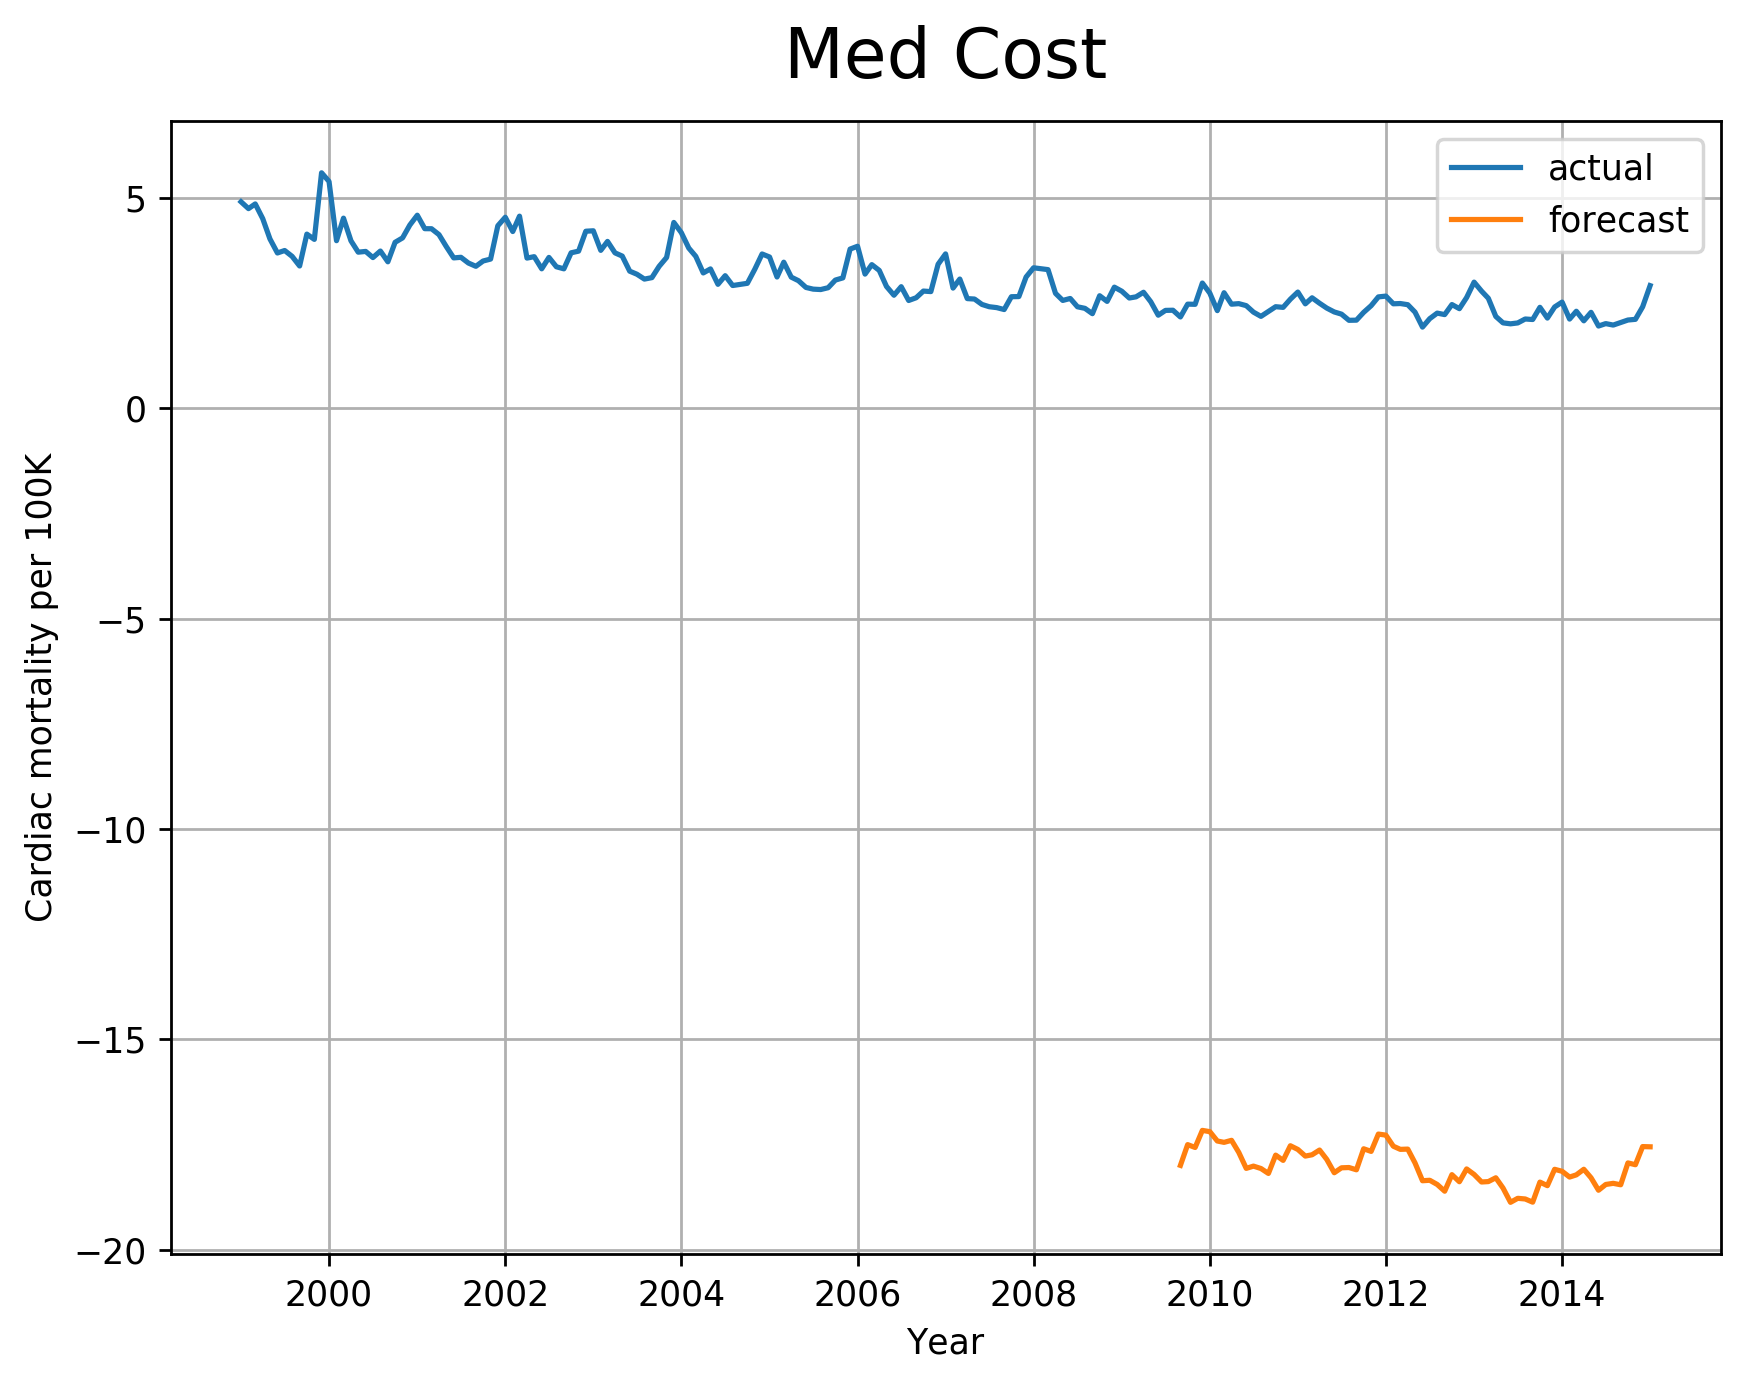

Maxing out gender in the test fraction:


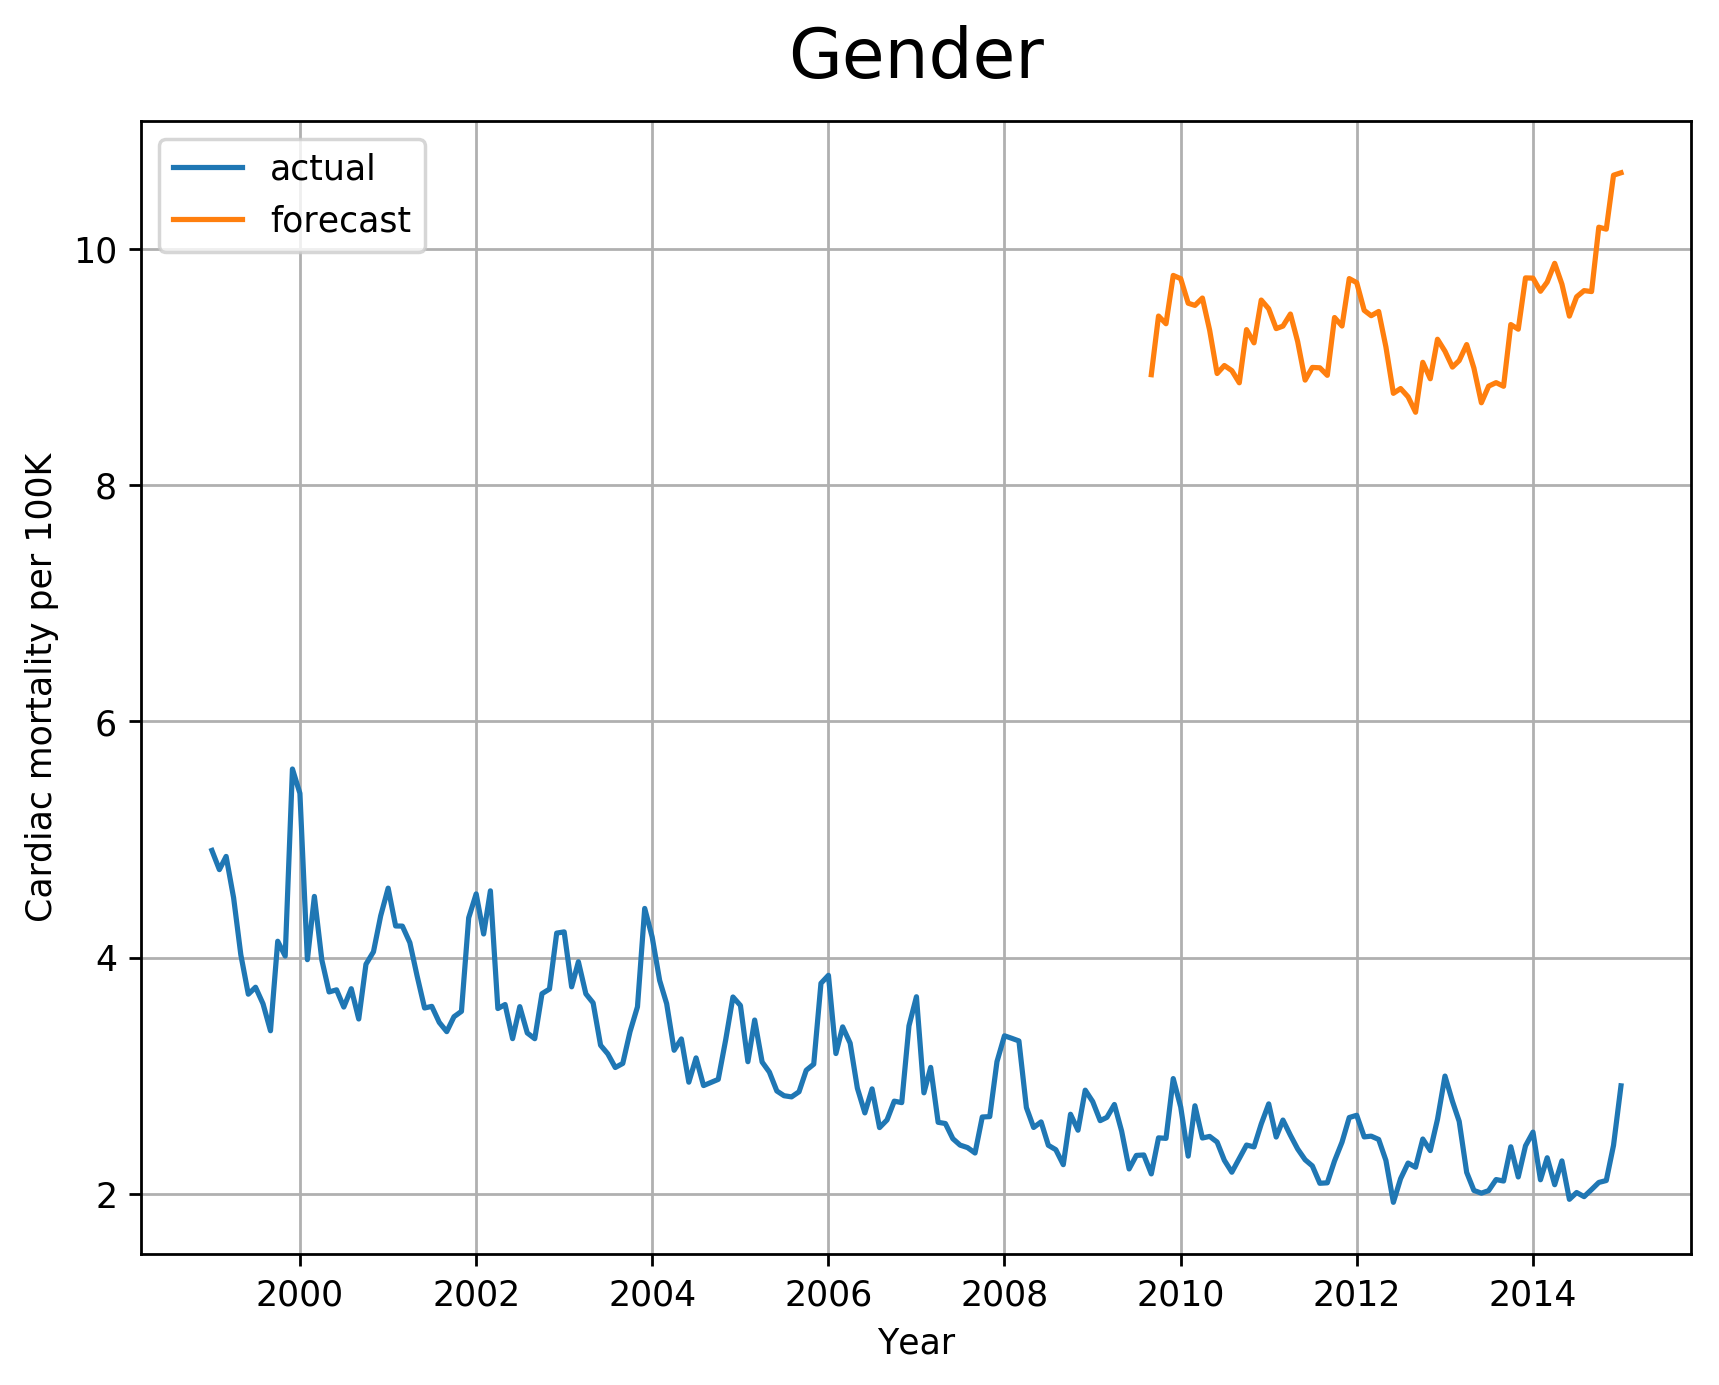

In [25]:
for var in X.columns:
    print(f"Maxing out {var} in the test fraction:")
    max_var_forecast = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[best_by_mse[0]], y, train_fraction=train_fraction, exog_var=max_variable_in_exog_df(var, X, train_fraction))

    plt.plot(state_df.mortality_per_100k, label="actual")
    plt.plot(max_var_forecast, label=f"forecast")
    plt.title(f"{var.title().replace('_', ' ')}", y=1.02, fontsize=20)

    #plt.title("Forecast with covariates vs actual cardiac mortality in California (trained on 10 years)", y = 1.02)

    plt.xlabel("Year")
    plt.ylabel("Cardiac mortality per 100K")

    plt.grid()
    plt.legend()
    
    plt.savefig(f"../figures_2/max_{var}_california_forecast.png", transparent=True)

    plt.show()